In [78]:
# Import ALL libraries we need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Load data
df = pd.read_csv('Breast Cancer METABRIC.csv')

print("="*70)
print("BREAST CANCER 10-YEAR MORTALITY PREDICTION PROJECT")
print("="*70)
print(f"\n Dataset loaded successfully!")
print(f" Total patients: {df.shape[0]}")
print(f" Total features: {df.shape[1]}")

BREAST CANCER 10-YEAR MORTALITY PREDICTION PROJECT

 Dataset loaded successfully!
 Total patients: 2509
 Total features: 34


In [ ]:
# IMPORTANT: Split data BEFORE any preprocessing

# Check if there are missing values in Overall Survival Status
print("Checking Overall Survival Status for missing values...")
print(f"Missing values: {df['Overall Survival Status'].isnull().sum()}")

# Simple split WITHOUT stratify (safer when data has missing values)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

print("\n" + "="*70)
print("DATA SPLIT")
print("="*70)
print(f"Training set: {train_df.shape[0]} patients ({train_df.shape[0]/df.shape[0]*100:.1f}%)")
print(f"Test set (held out): {test_df.shape[0]} patients ({test_df.shape[0]/df.shape[0]*100:.1f}%)")

# Check distribution in both sets
print("\nTraining set - Overall Survival Status:")
print(train_df['Overall Survival Status'].value_counts())
print("\nTest set - Overall Survival Status:")
print(test_df['Overall Survival Status'].value_counts())

# Save test set - DON'T TOUCH until final evaluation
test_df.to_csv('test_set_holdout.csv', index=False)
print("\n✅ Test set saved separately for final evaluation!")

# Work with training data only
df = train_df.copy()
print(f"\n📌 Working with {len(df)} patients for training and analysis")

Checking Overall Survival Status for missing values...
Missing values: 528

DATA SPLIT
Training set: 2007 patients (80.0%)
Test set (held out): 502 patients (20.0%)

Training set - Overall Survival Status:
Overall Survival Status
Deceased    922
Living      677
Name: count, dtype: int64

Test set - Overall Survival Status:
Overall Survival Status
Deceased    222
Living      160
Name: count, dtype: int64

✅ Test set saved separately for final evaluation!

📌 Working with 2007 patients for training and analysis



TARGET VARIABLE: 10-YEAR MORTALITY

📊 Distribution:
10_Year_Mortality
0    1387
1     620
Name: count, dtype: int64

📈 Percentage:
Survived 10+ years (0): 1387 (69.1%)
Died within 10 years (1): 620 (30.9%)


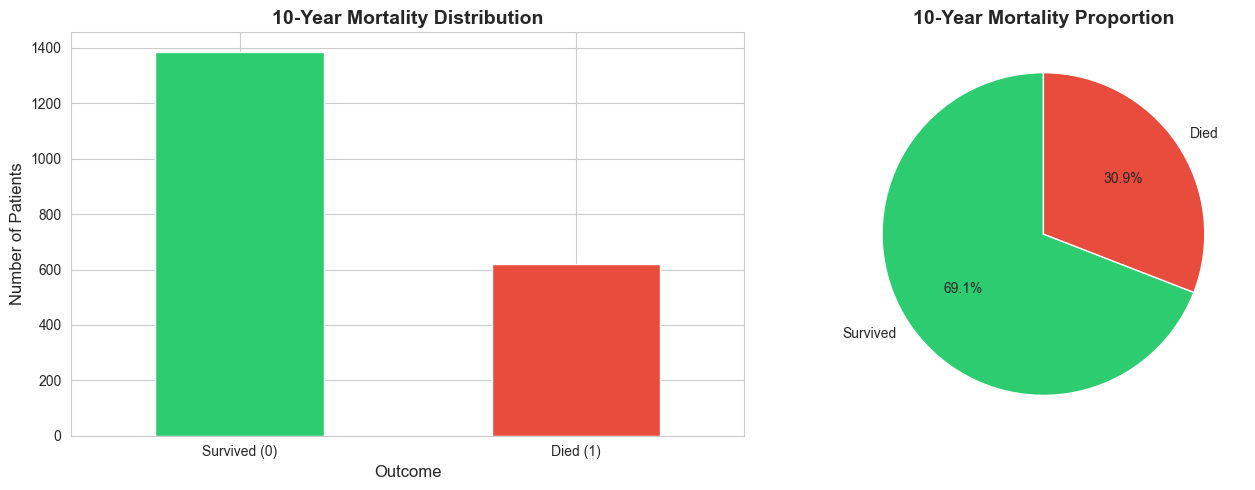

In [80]:
# Remove row with Alive patients whose survival months are less than 10yrs
df = df[
    ~(
        (df['Overall Survival Status'] == 'Alive') &
        (df['Overall Survival (Months)'] < 12)
    )
]
# Create 10-year (120 months) mortality target variable
df['10_Year_Mortality'] = 0  # Default: survived

# If patient died within 10 years (120 months), mark as 1
df.loc[(df['Overall Survival (Months)'] < 120) & 
       (df['Overall Survival Status'] == 'Deceased'), '10_Year_Mortality'] = 1



print("\n" + "="*70)
print("TARGET VARIABLE: 10-YEAR MORTALITY")
print("="*70)
print("\n📊 Distribution:")
print(df['10_Year_Mortality'].value_counts())
print("\n📈 Percentage:")
survival_counts = df['10_Year_Mortality'].value_counts()
print(f"Survived 10+ years (0): {survival_counts[0]} ({survival_counts[0]/len(df)*100:.1f}%)")
print(f"Died within 10 years (1): {survival_counts[1]} ({survival_counts[1]/len(df)*100:.1f}%)")

# Visualize
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
survival_counts.plot(kind='bar', ax=ax[0], color=['#2ecc71', '#e74c3c'])
ax[0].set_title('10-Year Mortality Distribution', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Outcome', fontsize=12)
ax[0].set_ylabel('Number of Patients', fontsize=12)
ax[0].set_xticklabels(['Survived (0)', 'Died (1)'], rotation=0)

# Pie chart
colors = ['#2ecc71', '#e74c3c']
ax[1].pie(survival_counts, labels=['Survived', 'Died'], autopct='%1.1f%%', 
          colors=colors, startangle=90)
ax[1].set_title('10-Year Mortality Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [81]:
# Basic information about our training data
print("="*70)
print("EXPLORATORY DATA ANALYSIS (EDA)")
print("="*70)

print("\n1️⃣ Dataset Overview:")
print(f"   - Number of patients: {df.shape[0]}")
print(f"   - Number of features: {df.shape[1]}")

print("\n2️⃣ Key Statistics:")
print(f"   - Average age at diagnosis: {df['Age at Diagnosis'].mean():.1f} years")
print(f"   - Age range: {df['Age at Diagnosis'].min():.1f} - {df['Age at Diagnosis'].max():.1f} years")
print(f"   - Average tumor size: {df['Tumor Size'].mean():.1f} mm")
print(f"   - Average survival time: {df['Overall Survival (Months)'].mean():.1f} months")

print("\n3️⃣ Missing Values Summary:")
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing[missing > 0],
    'Percentage': missing_pct[missing > 0]
}).sort_values('Missing_Count', ascending=False)

print(f"   - Columns with missing data: {len(missing_df)} out of {df.shape[1]}")
print(f"   - Most incomplete column: {missing_df.index[0]} ({missing_df.iloc[0]['Percentage']:.1f}% missing)")

EXPLORATORY DATA ANALYSIS (EDA)

1️⃣ Dataset Overview:
   - Number of patients: 2007
   - Number of features: 35

2️⃣ Key Statistics:
   - Average age at diagnosis: 60.5 years
   - Age range: 21.9 - 92.1 years
   - Average tumor size: 25.9 mm
   - Average survival time: 125.2 months

3️⃣ Missing Values Summary:
   - Columns with missing data: 29 out of 35
   - Most incomplete column: 3-Gene classifier subtype (29.2% missing)


In [82]:
df.columns

Index(['Patient ID', 'Age at Diagnosis', 'Type of Breast Surgery',
       'Cancer Type', 'Cancer Type Detailed', 'Cellularity', 'Chemotherapy',
       'Pam50 + Claudin-low subtype', 'Cohort', 'ER status measured by IHC',
       'ER Status', 'Neoplasm Histologic Grade',
       'HER2 status measured by SNP6', 'HER2 Status',
       'Tumor Other Histologic Subtype', 'Hormone Therapy',
       'Inferred Menopausal State', 'Integrative Cluster',
       'Primary Tumor Laterality', 'Lymph nodes examined positive',
       'Mutation Count', 'Nottingham prognostic index', 'Oncotree Code',
       'Overall Survival (Months)', 'Overall Survival Status', 'PR Status',
       'Radio Therapy', 'Relapse Free Status (Months)', 'Relapse Free Status',
       'Sex', '3-Gene classifier subtype', 'Tumor Size', 'Tumor Stage',
       'Patient's Vital Status', '10_Year_Mortality'],
      dtype='object')

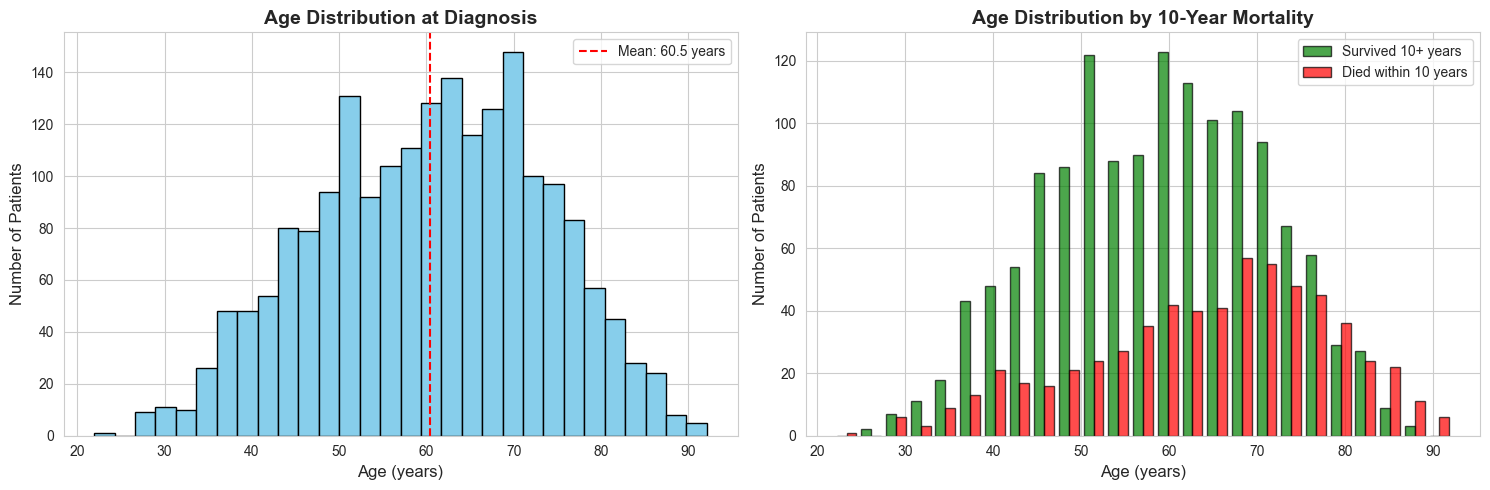

Average age - Survived: 58.7 years
Average age - Died: 64.3 years


In [83]:
# Age distribution analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Age distribution - overall
axes[0].hist(df['Age at Diagnosis'].dropna(), bins=30, color='skyblue', edgecolor='black')
axes[0].set_title('Age Distribution at Diagnosis', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Age (years)', fontsize=12)
axes[0].set_ylabel('Number of Patients', fontsize=12)
axes[0].axvline(df['Age at Diagnosis'].mean(), color='red', linestyle='--', 
                label=f'Mean: {df["Age at Diagnosis"].mean():.1f} years')
axes[0].legend()

# Age distribution by 10-year mortality
survived = df[df['10_Year_Mortality'] == 0]['Age at Diagnosis'].dropna()
died = df[df['10_Year_Mortality'] == 1]['Age at Diagnosis'].dropna()

axes[1].hist([survived, died], bins=25, label=['Survived 10+ years', 'Died within 10 years'], 
             color=['green', 'red'], alpha=0.7, edgecolor='black')
axes[1].set_title('Age Distribution by 10-Year Mortality', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Age (years)', fontsize=12)
axes[1].set_ylabel('Number of Patients', fontsize=12)
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Average age - Survived: {survived.mean():.1f} years")
print(f"Average age - Died: {died.mean():.1f} years")

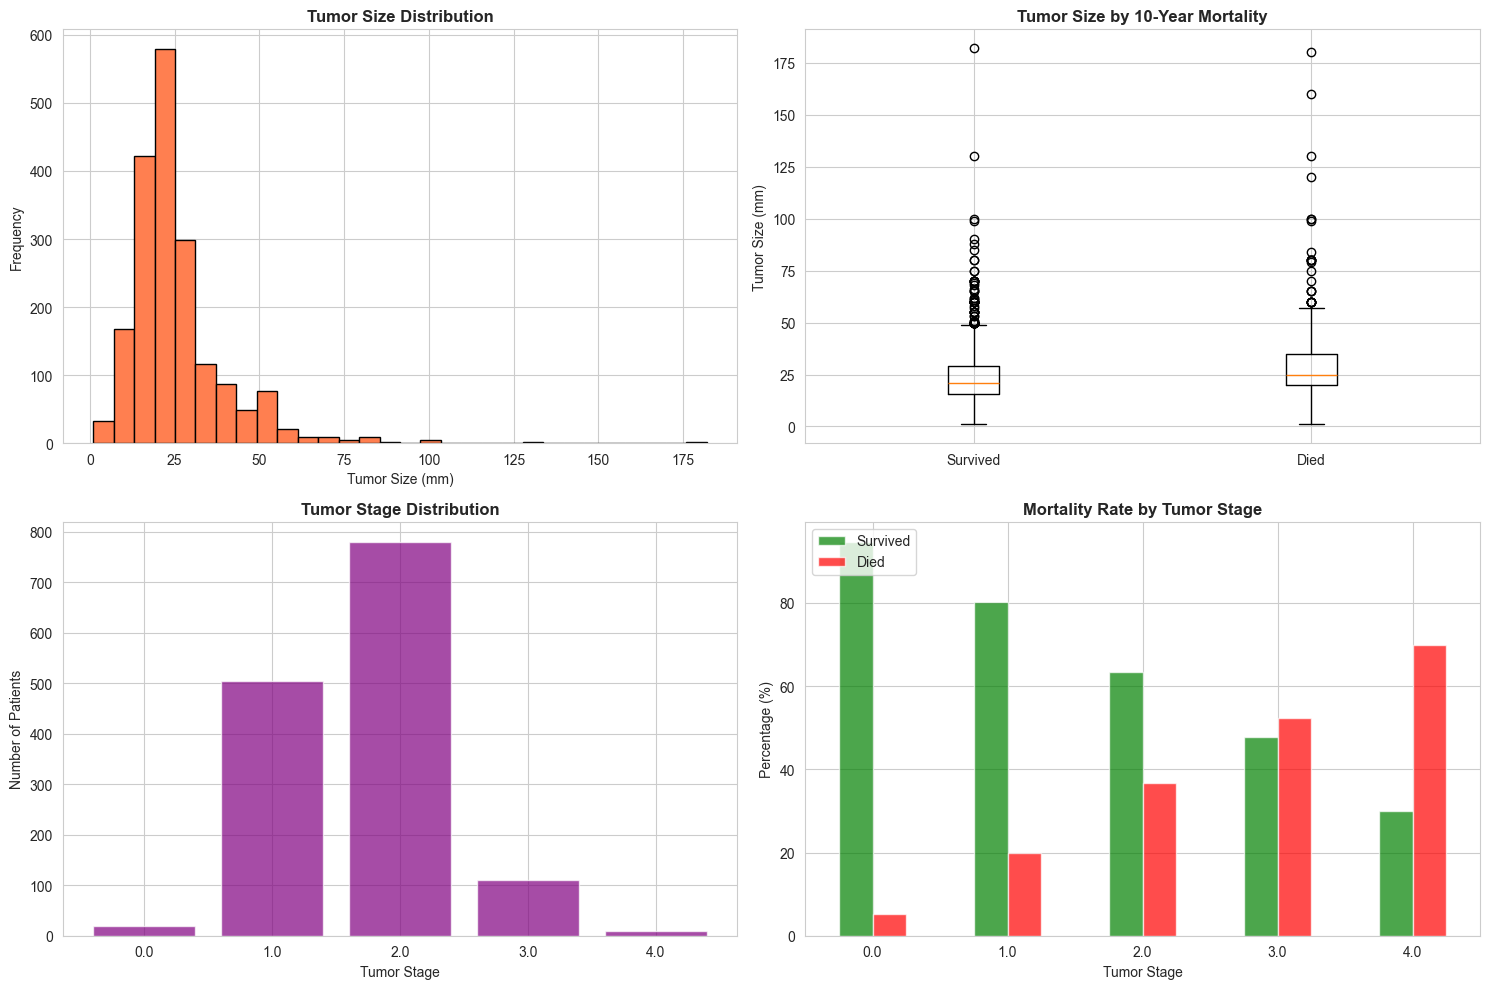


Tumor Size Statistics:
  Survived: Mean = 24.2 mm
  Died: Mean = 29.4 mm


In [84]:
# Tumor size and stage analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Tumor Size Distribution
axes[0, 0].hist(df['Tumor Size'].dropna(), bins=30, color='coral', edgecolor='black')
axes[0, 0].set_title('Tumor Size Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Tumor Size (mm)', fontsize=10)
axes[0, 0].set_ylabel('Frequency', fontsize=10)

# 2. Tumor Size by Mortality
tumor_survived = df[df['10_Year_Mortality'] == 0]['Tumor Size'].dropna()
tumor_died = df[df['10_Year_Mortality'] == 1]['Tumor Size'].dropna()
axes[0, 1].boxplot([tumor_survived, tumor_died], labels=['Survived', 'Died'])
axes[0, 1].set_title('Tumor Size by 10-Year Mortality', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Tumor Size (mm)', fontsize=10)

# 3. Tumor Stage Distribution
stage_counts = df['Tumor Stage'].value_counts().sort_index()
axes[1, 0].bar(stage_counts.index.astype(str), stage_counts.values, color='purple', alpha=0.7)
axes[1, 0].set_title('Tumor Stage Distribution', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Tumor Stage', fontsize=10)
axes[1, 0].set_ylabel('Number of Patients', fontsize=10)

# 4. Tumor Stage vs Mortality
stage_mortality = pd.crosstab(df['Tumor Stage'], df['10_Year_Mortality'], normalize='index') * 100
stage_mortality.plot(kind='bar', ax=axes[1, 1], color=['green', 'red'], alpha=0.7)
axes[1, 1].set_title('Mortality Rate by Tumor Stage', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Tumor Stage', fontsize=10)
axes[1, 1].set_ylabel('Percentage (%)', fontsize=10)
axes[1, 1].legend(['Survived', 'Died'], loc='upper left')
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

print(f"\nTumor Size Statistics:")
print(f"  Survived: Mean = {tumor_survived.mean():.1f} mm")
print(f"  Died: Mean = {tumor_died.mean():.1f} mm")

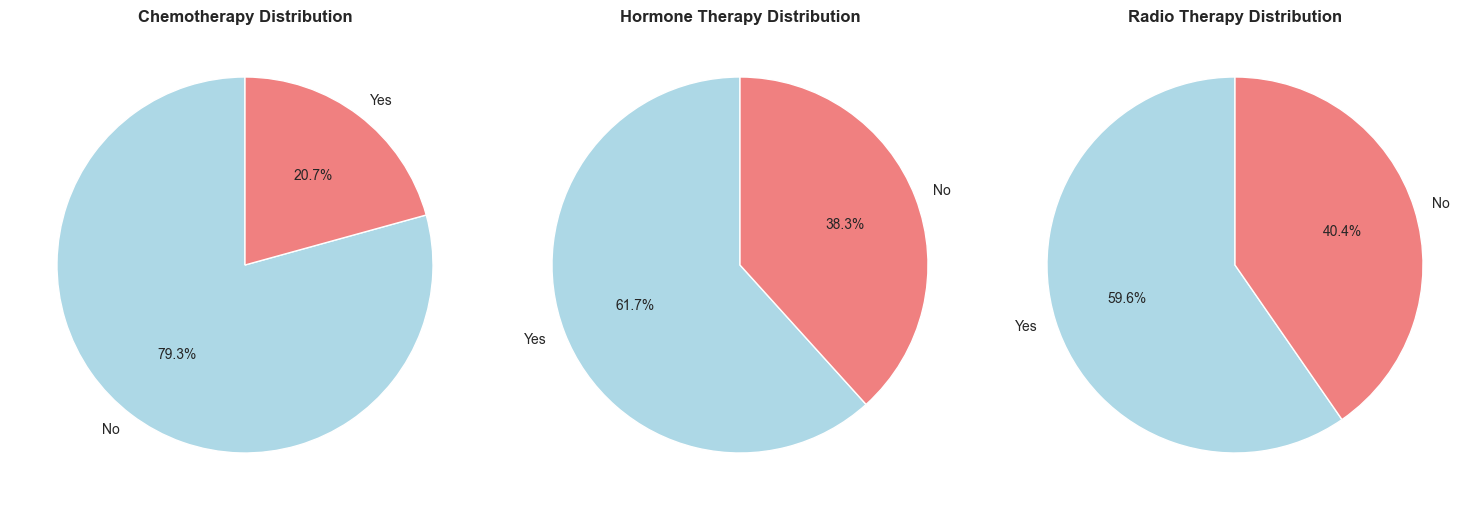


Treatment vs 10-Year Mortality:

Chemotherapy:
10_Year_Mortality          0          1
Chemotherapy                           
No                 63.062352  36.937648
Yes                54.078550  45.921450

Hormone Therapy:
10_Year_Mortality          0          1
Hormone Therapy                        
No                 62.745098  37.254902
Yes                60.243408  39.756592

Radio Therapy:
10_Year_Mortality          0          1
Radio Therapy                          
No                 56.589147  43.410853
Yes                64.323190  35.676810


In [85]:
# Treatment modalities analysis
treatments = ['Chemotherapy', 'Hormone Therapy', 'Radio Therapy']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, treatment in enumerate(treatments):
    # Count patients who received treatment
    treatment_counts = df[treatment].value_counts()
    
    axes[idx].pie(treatment_counts, labels=treatment_counts.index, autopct='%1.1f%%',
                  colors=['lightblue', 'lightcoral'], startangle=90)
    axes[idx].set_title(f'{treatment} Distribution', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Treatment effectiveness
print("\nTreatment vs 10-Year Mortality:")
for treatment in treatments:
    print(f"\n{treatment}:")
    treatment_mortality = pd.crosstab(df[treatment], df['10_Year_Mortality'], normalize='index') * 100
    print(treatment_mortality)

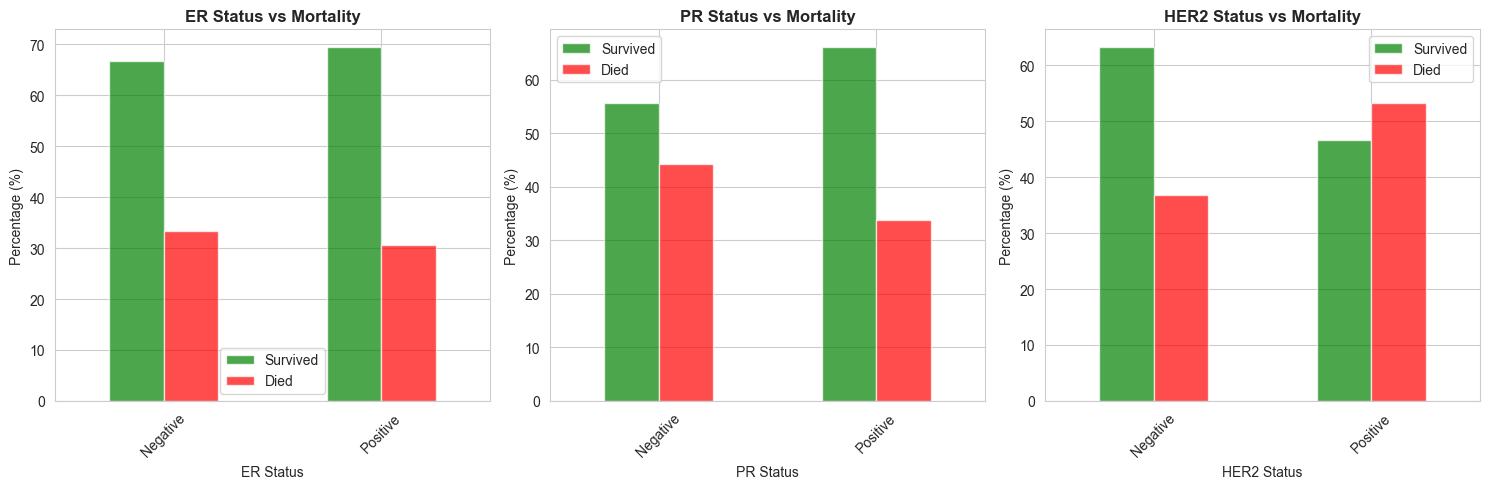


Biomarker Status Distribution:

ER Status:
ER Status
Positive    1470
Negative     513
Name: count, dtype: int64

PR Status:
PR Status
Positive    841
Negative    757
Name: count, dtype: int64

HER2 Status:
HER2 Status
Negative    1401
Positive     197
Name: count, dtype: int64


In [86]:
# Analyze key biomarkers
biomarkers = ['ER Status', 'PR Status', 'HER2 Status']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, marker in enumerate(biomarkers):
    # Mortality rate by biomarker status
    marker_data = pd.crosstab(df[marker], df['10_Year_Mortality'], normalize='index') * 100
    marker_data.plot(kind='bar', ax=axes[idx], color=['green', 'red'], alpha=0.7)
    axes[idx].set_title(f'{marker} vs Mortality', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(marker, fontsize=10)
    axes[idx].set_ylabel('Percentage (%)', fontsize=10)
    axes[idx].legend(['Survived', 'Died'])
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

print("\nBiomarker Status Distribution:")
for marker in biomarkers:
    print(f"\n{marker}:")
    print(df[marker].value_counts())

In [87]:
df.select_dtypes(include='number').columns

Index(['Age at Diagnosis', 'Cohort', 'Neoplasm Histologic Grade',
       'Lymph nodes examined positive', 'Mutation Count',
       'Nottingham prognostic index', 'Overall Survival (Months)',
       'Relapse Free Status (Months)', 'Tumor Size', 'Tumor Stage',
       '10_Year_Mortality'],
      dtype='object')

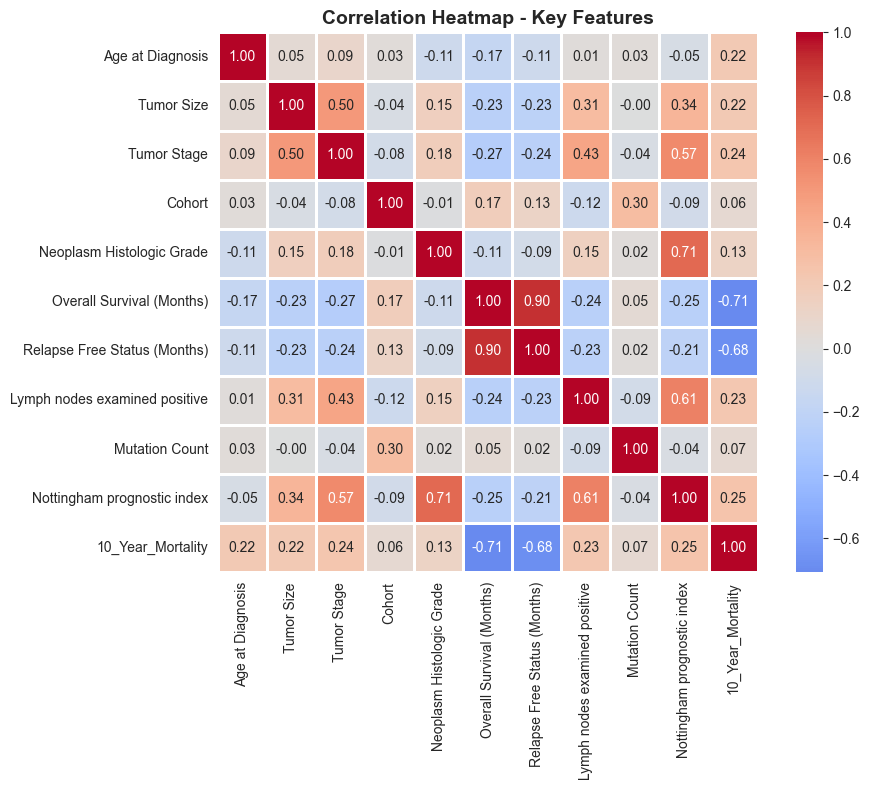


Correlation with 10-Year Mortality:
10_Year_Mortality                1.000000
Nottingham prognostic index      0.249667
Tumor Stage                      0.238506
Lymph nodes examined positive    0.231448
Tumor Size                       0.218930
Age at Diagnosis                 0.218630
Neoplasm Histologic Grade        0.130725
Mutation Count                   0.068845
Cohort                           0.060105
Relapse Free Status (Months)    -0.677657
Overall Survival (Months)       -0.707467
Name: 10_Year_Mortality, dtype: float64


In [88]:
# Select important numerical features for correlation analysis
numerical_cols = ['Age at Diagnosis', 'Tumor Size', 'Tumor Stage',
                  'Cohort', 'Neoplasm Histologic Grade',
                  'Overall Survival (Months)','Relapse Free Status (Months)', 
                  'Lymph nodes examined positive', 'Mutation Count',
                  'Nottingham prognostic index', '10_Year_Mortality']

# Create correlation matrix (drop missing values)
corr_data = df[numerical_cols].dropna()
correlation_matrix = corr_data.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1)
plt.title('Correlation Heatmap - Key Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nCorrelation with 10-Year Mortality:")
mortality_corr = correlation_matrix['10_Year_Mortality'].sort_values(ascending=False)
print(mortality_corr)

In [89]:
# Import survival analysis library
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test

print("✅ Survival analysis libraries imported successfully!")

✅ Survival analysis libraries imported successfully!


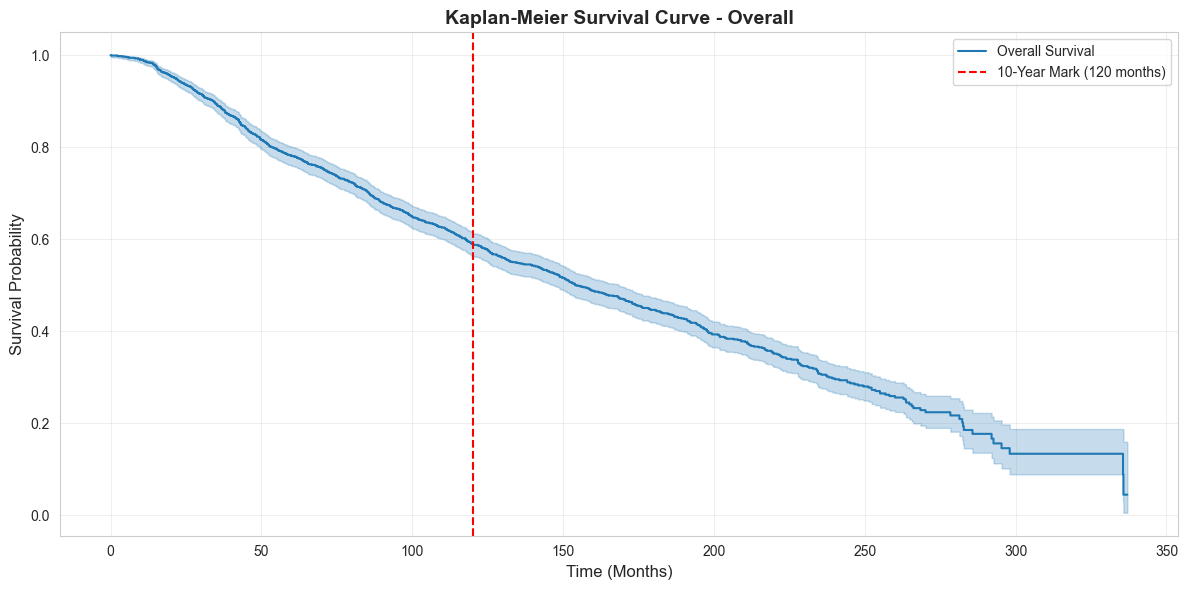

KAPLAN-MEIER SURVIVAL STATISTICS

Median survival time: 154.0 months

Survival probability at key timepoints:
  - 1 year (12 months): 98.5%
  - 5 years (60 months): 78.1%
  - 10 years (120 months): 58.9%
  - 15 years (180 months): 44.6%


In [90]:
# Prepare data for survival analysis
# We need: time (months) and event (1=died, 0=censored/alive)
survival_data = df[['Overall Survival (Months)', 'Overall Survival Status']].copy()
survival_data = survival_data.dropna()

# Convert status to binary (1=event occurred, 0=censored)
survival_data['Event'] = (survival_data['Overall Survival Status'] == 'Deceased').astype(int)

# Fit Kaplan-Meier model
kmf = KaplanMeierFitter()
kmf.fit(durations=survival_data['Overall Survival (Months)'], 
        event_observed=survival_data['Event'],
        label='Overall Survival')

# Plot survival curve
plt.figure(figsize=(12, 6))
kmf.plot_survival_function()
plt.title('Kaplan-Meier Survival Curve - Overall', fontsize=14, fontweight='bold')
plt.xlabel('Time (Months)', fontsize=12)
plt.ylabel('Survival Probability', fontsize=12)
plt.axvline(x=120, color='red', linestyle='--', label='10-Year Mark (120 months)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print survival statistics
print("="*70)
print("KAPLAN-MEIER SURVIVAL STATISTICS")
print("="*70)
print(f"\nMedian survival time: {kmf.median_survival_time_:.1f} months")
print(f"\nSurvival probability at key timepoints:")
print(f"  - 1 year (12 months): {kmf.predict(12):.1%}")
print(f"  - 5 years (60 months): {kmf.predict(60):.1%}")
print(f"  - 10 years (120 months): {kmf.predict(120):.1%}")
print(f"  - 15 years (180 months): {kmf.predict(180):.1%}")

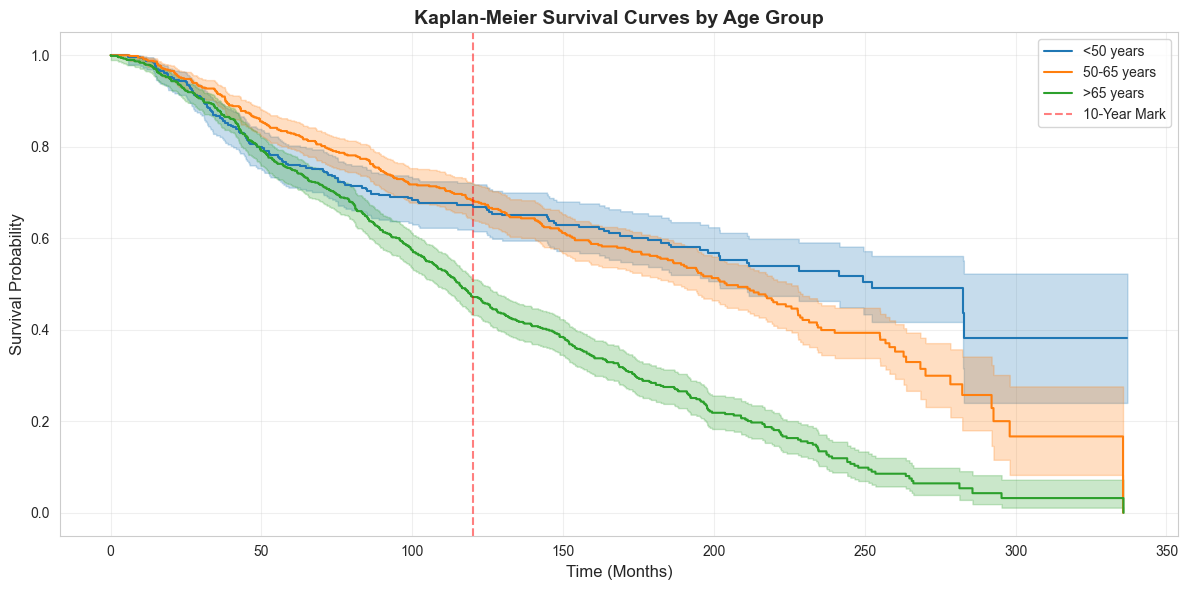


LOG-RANK TEST - Comparing Age Groups

Comparing <50 years vs >65 years:
  p-value: 0.0000
  ✅ Statistically significant difference (p < 0.05)


In [91]:
# Divide patients into age groups
survival_data['Age_Group'] = pd.cut(df.loc[survival_data.index, 'Age at Diagnosis'], 
                                     bins=[0, 50, 65, 100], 
                                     labels=['<50 years', '50-65 years', '>65 years'])

# Plot survival curves by age group
plt.figure(figsize=(12, 6))

for age_group in ['<50 years', '50-65 years', '>65 years']:
    mask = survival_data['Age_Group'] == age_group
    kmf_age = KaplanMeierFitter()
    kmf_age.fit(durations=survival_data.loc[mask, 'Overall Survival (Months)'],
                event_observed=survival_data.loc[mask, 'Event'],
                label=age_group)
    kmf_age.plot_survival_function(ax=plt.gca())

plt.title('Kaplan-Meier Survival Curves by Age Group', fontsize=14, fontweight='bold')
plt.xlabel('Time (Months)', fontsize=12)
plt.ylabel('Survival Probability', fontsize=12)
plt.axvline(x=120, color='red', linestyle='--', alpha=0.5, label='10-Year Mark')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Log-rank test to compare survival curves
print("\n" + "="*70)
print("LOG-RANK TEST - Comparing Age Groups")
print("="*70)
group1 = survival_data[survival_data['Age_Group'] == '<50 years']
group2 = survival_data[survival_data['Age_Group'] == '>65 years']

results = logrank_test(
    group1['Overall Survival (Months)'], group2['Overall Survival (Months)'],
    group1['Event'], group2['Event']
)
print(f"\nComparing <50 years vs >65 years:")
print(f"  p-value: {results.p_value:.4f}")
if results.p_value < 0.05:
    print("  ✅ Statistically significant difference (p < 0.05)")
else:
    print("  ❌ No significant difference (p >= 0.05)")

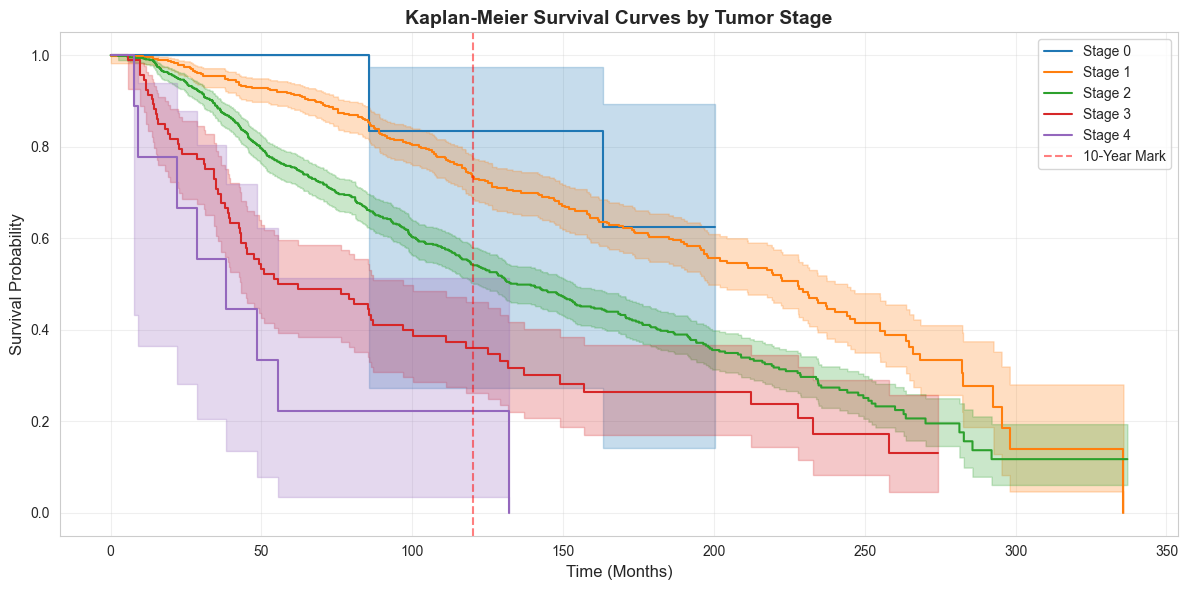

In [92]:
# Survival curves by tumor stage
survival_data['Tumor_Stage'] = df.loc[survival_data.index, 'Tumor Stage']
survival_data_stage = survival_data.dropna(subset=['Tumor_Stage'])

plt.figure(figsize=(12, 6))

for stage in sorted(survival_data_stage['Tumor_Stage'].unique()):
    mask = survival_data_stage['Tumor_Stage'] == stage
    kmf_stage = KaplanMeierFitter()
    kmf_stage.fit(durations=survival_data_stage.loc[mask, 'Overall Survival (Months)'],
                  event_observed=survival_data_stage.loc[mask, 'Event'],
                  label=f'Stage {int(stage)}')
    kmf_stage.plot_survival_function(ax=plt.gca())

plt.title('Kaplan-Meier Survival Curves by Tumor Stage', fontsize=14, fontweight='bold')
plt.xlabel('Time (Months)', fontsize=12)
plt.ylabel('Survival Probability', fontsize=12)
plt.axvline(x=120, color='red', linestyle='--', alpha=0.5, label='10-Year Mark')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [93]:
# Prepare data for Cox model
# Select important features
cox_data = df[['Overall Survival (Months)', 'Overall Survival Status',
               'Age at Diagnosis', 'Tumor Size', 'Tumor Stage',
               'Lymph nodes examined positive', 'ER Status', 'PR Status', 
               'HER2 Status', 'Chemotherapy', 'Hormone Therapy', 'Radio Therapy']].copy()

# Convert status to binary
cox_data['Event'] = (cox_data['Overall Survival Status'] == 'Deceased').astype(int)

# Encode categorical variables
cox_data['ER_Positive'] = (cox_data['ER Status'] == 'Positive').astype(int)
cox_data['PR_Positive'] = (cox_data['PR Status'] == 'Positive').astype(int)
cox_data['HER2_Positive'] = (cox_data['HER2 Status'] == 'Positive').astype(int)
cox_data['Chemo_Yes'] = (cox_data['Chemotherapy'] == 'Yes').astype(int)
cox_data['Hormone_Yes'] = (cox_data['Hormone Therapy'] == 'Yes').astype(int)
cox_data['Radio_Yes'] = (cox_data['Radio Therapy'] == 'Yes').astype(int)

# Select final features for Cox model
cox_features = ['Age at Diagnosis', 'Tumor Size', 'Tumor Stage',
                'Lymph nodes examined positive', 'ER_Positive', 'PR_Positive',
                'HER2_Positive', 'Chemo_Yes', 'Hormone_Yes', 'Radio_Yes']

cox_data_final = cox_data[['Overall Survival (Months)', 'Event'] + cox_features].dropna()

# Fit Cox Proportional Hazards model
cph = CoxPHFitter()
cph.fit(cox_data_final, duration_col='Overall Survival (Months)', event_col='Event')

print("="*70)
print("COX PROPORTIONAL HAZARDS MODEL RESULTS")
print("="*70)
print("\nModel Summary:")
print(cph.summary)

print("\n" + "="*70)
print("INTERPRETATION:")
print("="*70)
print("\nHazard Ratios (exp(coef)):")
print("- HR > 1: Increases risk of death (BAD)")
print("- HR < 1: Decreases risk of death (GOOD)")
print("- p < 0.05: Statistically significant")
print("\n")
for feature in cox_features:
    hr = cph.summary.loc[feature, 'exp(coef)']
    p_val = cph.summary.loc[feature, 'p']
    sig = "✅ Significant" if p_val < 0.05 else "❌ Not significant"
    direction = "⬆️ INCREASES risk" if hr > 1 else "⬇️ DECREASES risk"
    print(f"{feature:30s}: HR = {hr:.3f}, p = {p_val:.4f} {sig} - {direction}")

COX PROPORTIONAL HAZARDS MODEL RESULTS

Model Summary:
                                   coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                                      
Age at Diagnosis               0.041922   1.042813  0.004004        0.034075   
Tumor Size                     0.008045   1.008077  0.002420        0.003302   
Tumor Stage                    0.262917   1.300718  0.078795        0.108482   
Lymph nodes examined positive  0.055997   1.057594  0.010286        0.035837   
ER_Positive                   -0.139653   0.869660  0.130662       -0.395746   
PR_Positive                   -0.030585   0.969878  0.093255       -0.213362   
HER2_Positive                  0.417877   1.518733  0.128851        0.165333   
Chemo_Yes                      0.161543   1.175323  0.140394       -0.113624   
Hormone_Yes                   -0.175122   0.839355  0.095768       -0.362824   
Radio_Yes                     -0.267822   0.765044  0.086174     

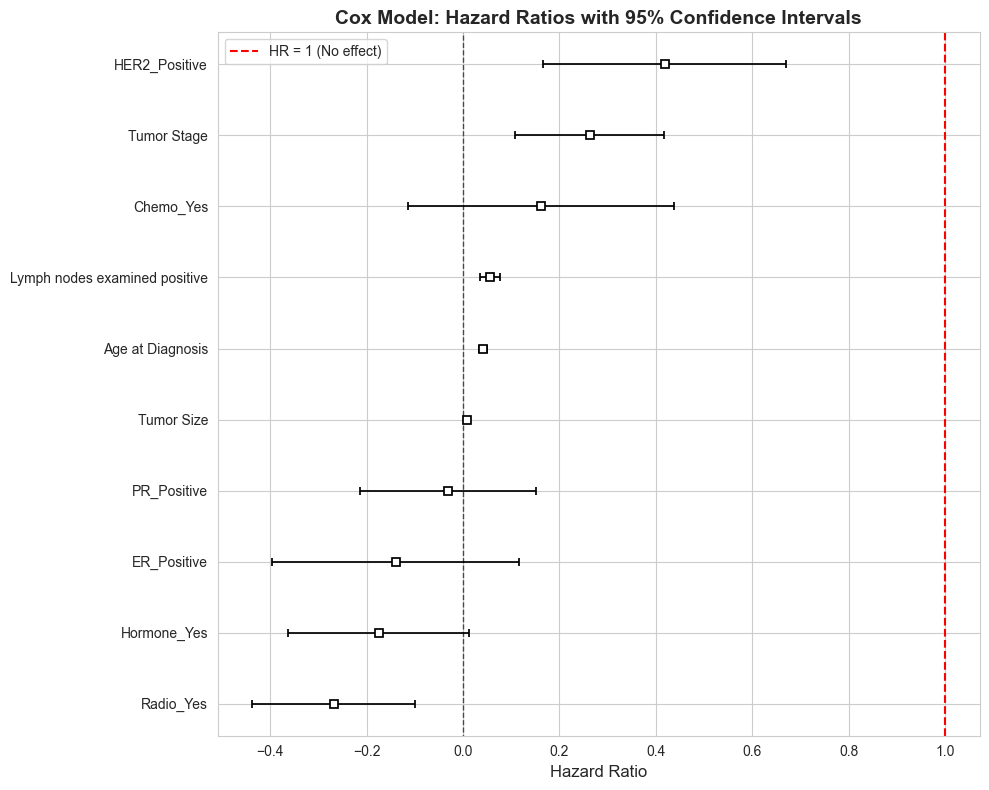

In [94]:
# Plot hazard ratios
plt.figure(figsize=(10, 8))
cph.plot()
plt.title('Cox Model: Hazard Ratios with 95% Confidence Intervals', fontsize=14, fontweight='bold')
plt.axvline(x=1, color='red', linestyle='--', label='HR = 1 (No effect)')
plt.xlabel('Hazard Ratio', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

In [95]:
print("="*70)
print("PHASE 4: DATA PREPROCESSING FOR MACHINE LEARNING")
print("="*70)

# Select features for modeling
# We'll use important clinical features
feature_columns = [
    'Age at Diagnosis', 'Tumor Size','Mutation Count',
    'Lymph nodes examined positive','Tumor Stage','HER2 Status','Chemotherapy',
    'Nottingham prognostic index','ER Status',
    'Neoplasm Histologic Grade',
    'PR Status','Hormone Therapy', 'Radio Therapy',
    'Type of Breast Surgery', 'Cellularity','Pam50 + Claudin-low subtype',
    '3-Gene classifier subtype','Primary Tumor Laterality'
]

target_column = '10_Year_Mortality'

# Create modeling dataset
model_data = df[feature_columns + [target_column]].copy()

print(f"\n📊 Initial dataset size: {model_data.shape}")
print(f"   Features: {len(feature_columns)}")
print(f"   Samples: {model_data.shape[0]}")

# Check missing values
print(f"\n❓ Missing values per feature:")
missing_before = model_data.isnull().sum()
print(missing_before[missing_before > 0].sort_values(ascending=False))

PHASE 4: DATA PREPROCESSING FOR MACHINE LEARNING

📊 Initial dataset size: (2007, 19)
   Features: 18
   Samples: 2007

❓ Missing values per feature:
3-Gene classifier subtype        586
Tumor Stage                      582
Primary Tumor Laterality         493
Cellularity                      460
Type of Breast Surgery           431
Hormone Therapy                  409
PR Status                        409
HER2 Status                      409
Chemotherapy                     409
Radio Therapy                    409
Pam50 + Claudin-low subtype      409
Lymph nodes examined positive    200
Nottingham prognostic index      177
Mutation Count                   119
Tumor Size                       112
Neoplasm Histologic Grade         95
ER Status                         24
Age at Diagnosis                   6
dtype: int64


In [ ]:
print("\n" + "="*70)
print("FEATURE ENGINEERING")
print("="*70)

# Create new features
model_data['Age_Group'] = pd.cut(model_data['Age at Diagnosis'], 
                                  bins=[0, 40, 60, 100], 
                                  labels=['Young', 'Middle', 'Old'])

model_data['Tumor_Size_Category'] = pd.cut(model_data['Tumor Size'], 
                                            bins=[0, 20, 50, 200], 
                                            labels=['Small', 'Medium', 'Large'])

model_data['High_Risk_Nodes'] = (model_data['Lymph nodes examined positive'] > 3).astype(int)

model_data['Age_Tumor_Interaction'] = model_data['Age at Diagnosis'] * model_data['Tumor Size']

print("✅ New features created:")
print("   - Age_Group, Tumor_Size_Category, High_Risk_Nodes")
print("   - Age_Tumor_Interaction")


FEATURE ENGINEERING
✅ New features created:
   - Age_Group, Tumor_Size_Category, High_Risk_Nodes
   - Age_Tumor_Interaction, Triple_Negative


In [97]:
from sklearn.impute import SimpleImputer

print("\n" + "="*70)
print("HANDLING MISSING VALUES")
print("="*70)

# Separate numerical and categorical columns
numerical_cols = model_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = model_data.select_dtypes(include=['object', 'category']).columns.tolist()

# Remove target from lists if present
if target_column in numerical_cols:
    numerical_cols.remove(target_column)
if target_column in categorical_cols:
    categorical_cols.remove(target_column)

print(f"\n📊 Numerical features: {len(numerical_cols)}")
print(f"📊 Categorical features: {len(categorical_cols)}")

# Impute numerical columns with median
num_imputer = SimpleImputer(strategy='median')
model_data[numerical_cols] = num_imputer.fit_transform(model_data[numerical_cols])

# Impute categorical columns with most frequent value
cat_imputer = SimpleImputer(strategy='most_frequent')
model_data[categorical_cols] = cat_imputer.fit_transform(model_data[categorical_cols])

print(f"\n✅ Missing values after imputation: {model_data.isnull().sum().sum()}")

# Drop rows where target is missing
model_data = model_data.dropna(subset=[target_column])
print(f"✅ Final dataset size: {model_data.shape}")



HANDLING MISSING VALUES

📊 Numerical features: 9
📊 Categorical features: 13

✅ Missing values after imputation: 0
✅ Final dataset size: (2007, 23)


In [98]:
model_data.columns.tolist

<bound method IndexOpsMixin.tolist of Index(['Age at Diagnosis', 'Tumor Size', 'Mutation Count',
       'Lymph nodes examined positive', 'Tumor Stage', 'HER2 Status',
       'Chemotherapy', 'Nottingham prognostic index', 'ER Status',
       'Neoplasm Histologic Grade', 'PR Status', 'Hormone Therapy',
       'Radio Therapy', 'Type of Breast Surgery', 'Cellularity',
       'Pam50 + Claudin-low subtype', '3-Gene classifier subtype',
       'Primary Tumor Laterality', '10_Year_Mortality', 'Age_Group',
       'Tumor_Size_Category', 'High_Risk_Nodes', 'Age_Tumor_Interaction'],
      dtype='object')>

In [99]:
from sklearn.preprocessing import LabelEncoder

print("\n" + "="*70)
print("ENCODING CATEGORICAL VARIABLES")
print("="*70)

# Create label encoders for each categorical column
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    model_data[col] = le.fit_transform(model_data[col].astype(str))
    label_encoders[col] = le
    print(f"✅ Encoded: {col} ({len(le.classes_)} categories)")

print(f"\n✅ All categorical variables encoded!")


ENCODING CATEGORICAL VARIABLES
✅ Encoded: HER2 Status (2 categories)
✅ Encoded: Chemotherapy (2 categories)
✅ Encoded: ER Status (2 categories)
✅ Encoded: PR Status (2 categories)
✅ Encoded: Hormone Therapy (2 categories)
✅ Encoded: Radio Therapy (2 categories)
✅ Encoded: Type of Breast Surgery (2 categories)
✅ Encoded: Cellularity (3 categories)
✅ Encoded: Pam50 + Claudin-low subtype (7 categories)
✅ Encoded: 3-Gene classifier subtype (4 categories)
✅ Encoded: Primary Tumor Laterality (2 categories)
✅ Encoded: Age_Group (3 categories)
✅ Encoded: Tumor_Size_Category (3 categories)

✅ All categorical variables encoded!


In [100]:
model_data.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['Age at Diagnosis', 'Tumor Size', 'Mutation Count',
       'Lymph nodes examined positive', 'Tumor Stage', 'HER2 Status',
       'Chemotherapy', 'Nottingham prognostic index', 'ER Status',
       'Neoplasm Histologic Grade', 'PR Status', 'Hormone Therapy',
       'Radio Therapy', 'Type of Breast Surgery', 'Cellularity',
       'Pam50 + Claudin-low subtype', '3-Gene classifier subtype',
       'Primary Tumor Laterality', '10_Year_Mortality', 'Age_Group',
       'Tumor_Size_Category', 'High_Risk_Nodes', 'Age_Tumor_Interaction'],
      dtype='object')>

In [101]:
print("\n" + "="*70)
print("PREPARING FEATURES AND TARGET")
print("="*70)

# Separate features (X) and target (y)
X_train = model_data.drop(columns=[target_column])
y_train = model_data[target_column]

print(f"\n📊 Training Features Shape: {X_train.shape}")
print(f"📊 Training Target Shape: {y_train.shape}")

print(f"\n📈 Target Distribution (Training Set):")
print(y_train.value_counts())
print(f"\n   Survived (0): {(y_train == 0).sum()} ({(y_train == 0).sum()/len(y_train)*100:.1f}%)")
print(f"   Died (1): {(y_train == 1).sum()} ({(y_train == 1).sum()/len(y_train)*100:.1f}%)")


PREPARING FEATURES AND TARGET

📊 Training Features Shape: (2007, 22)
📊 Training Target Shape: (2007,)

📈 Target Distribution (Training Set):
10_Year_Mortality
0    1387
1     620
Name: count, dtype: int64

   Survived (0): 1387 (69.1%)
   Died (1): 620 (30.9%)


In [102]:
X_train[categorical_cols].dtypes


HER2 Status                    int64
Chemotherapy                   int64
ER Status                      int64
PR Status                      int64
Hormone Therapy                int64
Radio Therapy                  int64
Type of Breast Surgery         int64
Cellularity                    int64
Pam50 + Claudin-low subtype    int64
3-Gene classifier subtype      int64
Primary Tumor Laterality       int64
Age_Group                      int64
Tumor_Size_Category            int64
dtype: object

In [103]:
from sklearn.preprocessing import StandardScaler

print("\n" + "="*70)
print("FEATURE SCALING")
print("="*70)

# Scale features (important for SVM and Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

print(f"✅ Features scaled using StandardScaler")
print(f"\nExample - Before scaling:")
print(X_train.head(3))
print(f"\nExample - After scaling:")
print(X_train_scaled.head(3))


FEATURE SCALING
✅ Features scaled using StandardScaler

Example - Before scaling:
      Age at Diagnosis  Tumor Size  Mutation Count  \
1779              45.3        50.0             4.0   
2279              51.0        22.0             3.0   
406               39.3        23.0             4.0   

      Lymph nodes examined positive  Tumor Stage  HER2 Status  Chemotherapy  \
1779                           13.0          2.0            1             1   
2279                            0.0          2.0            0             0   
406                             5.0          2.0            0             1   

      Nottingham prognostic index  ER Status  Neoplasm Histologic Grade  ...  \
1779                        6.100          0                        3.0  ...   
2279                        4.042          1                        3.0  ...   
406                         6.046          1                        3.0  ...   

      Radio Therapy  Type of Breast Surgery  Cellularity  \
17

In [ ]:
print("\n" + "="*70)
print("PHASE 5: MACHINE LEARNING MODELS")
print("="*70)

# Import models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Import evaluation metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, roc_curve, 
                             confusion_matrix, classification_report)
from sklearn.model_selection import cross_val_score

print("✅ All libraries imported successfully!")


PHASE 5: MACHINE LEARNING MODELS
✅ All libraries imported successfully!


In [105]:
print("\n" + "="*70)
print("TRAINING MODELS WITH HYPERPARAMETER TUNING")
print("="*70)

from sklearn.model_selection import GridSearchCV

# Define models with hyperparameter grids
models_with_params = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'params': {
            'C': [0.01, 0.1, 1, 10, 100],
            'penalty': ['l2'],
            'solver': ['lbfgs', 'liblinear']
        }
    },
    
    'Support Vector Machine': {
        'model': SVC(probability=True, random_state=42),
        'params': {
            'C': [0.1, 1, 10, 100],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']
        }
    },
    
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'max_depth': [3, 5, 7, 10, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'criterion': ['gini', 'entropy']
        }
    },
    
    'Random Forest - Config 1': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2],
            'max_features': ['sqrt', 'log2']
        }
    },
    
    'Random Forest - Config 2': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [150, 250],
            'max_depth': [15, None],
            'min_samples_split': [3, 7],
            'min_samples_leaf': [1, 3],
            'max_features': ['sqrt']
        }
    },
    
    'Random Forest - Config 3': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100],
            'max_depth': [5, 10, 15],
            'min_samples_split': [5, 10],
            'min_samples_leaf': [2, 4],
            'criterion': ['gini', 'entropy']
        }
    },
    
    'Random Forest - Config 4': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [200, 300],
            'max_depth': [None],
            'min_samples_split': [2],
            'min_samples_leaf': [1],
            'max_features': ['sqrt', 'log2'],
            'bootstrap': [True, False]
        }
    },
    
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 1.0]
        }
    }
}

# Dictionary to store best models and results
best_models = {}
results = {}

print("\n🔍 Starting Hyperparameter Tuning (This may take a few minutes)...\n")

# Train each model with GridSearchCV
for name, config in models_with_params.items():
    print(f"\n{'='*70}")
    print(f"🔄 Tuning {name}...")
    print(f"{'='*70}")
    
    # GridSearchCV with 5-fold cross-validation
    grid_search = GridSearchCV(
        estimator=config['model'],
        param_grid=config['params'],
        cv=5,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )
    
    # Fit the grid search
    grid_search.fit(X_train_scaled, y_train)
    
    # Get best model
    best_model = grid_search.best_estimator_
    best_models[name] = best_model
    
    # Print best parameters
    print(f"\n✅ Best Parameters for {name}:")
    for param, value in grid_search.best_params_.items():
        print(f"   - {param}: {value}")
    
    # Make predictions with best model and custom threshold
    y_train_pred_proba = best_model.predict_proba(X_train_scaled)[:, 1]
    
    # Apply custom threshold
    threshold = 0.3
    y_train_pred = (y_train_pred_proba >= threshold).astype(int)
    
    # Calculate metrics
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_precision = precision_score(y_train, y_train_pred, zero_division=0)
    train_recall = recall_score(y_train, y_train_pred, zero_division=0)
    train_f1 = f1_score(y_train, y_train_pred, zero_division=0)
    train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
    
    # Cross-validation score
    cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
    
    # Store results
    results[name] = {
        'model': best_model,
        'algorithm': config['model'].__class__.__name__,
        'best_params': grid_search.best_params_,
        'train_accuracy': train_accuracy,
        'train_precision': train_precision,
        'train_recall': train_recall,
        'train_f1': train_f1,
        'train_roc_auc': train_roc_auc,
        'cv_roc_auc_mean': cv_scores.mean(),
        'cv_roc_auc_std': cv_scores.std(),
        'y_train_pred': y_train_pred,
        'y_train_pred_proba': y_train_pred_proba
    }
    
    print(f"\n📊 Training Results:")
    print(f"   Accuracy:  {train_accuracy:.4f}")
    print(f"   Precision: {train_precision:.4f}")
    print(f"   Recall:    {train_recall:.4f}")
    print(f"   F1-Score:  {train_f1:.4f}")
    print(f"   ROC-AUC:   {train_roc_auc:.4f}")
    print(f"   CV ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

print("\n" + "="*70)
print("✅ ALL MODELS TUNED SUCCESSFULLY!")
print("="*70)

# Update models dictionary with best models for later use
models = best_models


TRAINING MODELS WITH HYPERPARAMETER TUNING

🔍 Starting Hyperparameter Tuning (This may take a few minutes)...


🔄 Tuning Logistic Regression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

✅ Best Parameters for Logistic Regression:
   - C: 0.1
   - penalty: l2
   - solver: lbfgs

📊 Training Results:
   Accuracy:  0.6866
   Precision: 0.4950
   Recall:    0.7242
   F1-Score:  0.5881
   ROC-AUC:   0.7846
   CV ROC-AUC: 0.7773 (+/- 0.0119)

🔄 Tuning Support Vector Machine...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

✅ Best Parameters for Support Vector Machine:
   - C: 0.1
   - gamma: scale
   - kernel: linear

📊 Training Results:
   Accuracy:  0.6941
   Precision: 0.5034
   Recall:    0.7081
   F1-Score:  0.5885
   ROC-AUC:   0.7826
   CV ROC-AUC: 0.7707 (+/- 0.0148)

🔄 Tuning Decision Tree...
Fitting 5 folds for each of 90 candidates, totalling 450 fits

✅ Best Parameters for Decision Tree:
   - criterion: gini
   - max_depth: 5
   - min_samples_lea

In [106]:
print("\n" + "="*70)
print("BEST HYPERPARAMETERS FOR EACH MODEL")
print("="*70)

for name, result in results.items():
    print(f"\n🔧 {name}:")
    print("-" * 50)
    for param, value in result['best_params'].items():
        print(f"   {param:25s}: {value}")


BEST HYPERPARAMETERS FOR EACH MODEL

🔧 Logistic Regression:
--------------------------------------------------
   C                        : 0.1
   penalty                  : l2
   solver                   : lbfgs

🔧 Support Vector Machine:
--------------------------------------------------
   C                        : 0.1
   gamma                    : scale
   kernel                   : linear

🔧 Decision Tree:
--------------------------------------------------
   criterion                : gini
   max_depth                : 5
   min_samples_leaf         : 1
   min_samples_split        : 2

🔧 Random Forest - Config 1:
--------------------------------------------------
   max_depth                : 10
   max_features             : sqrt
   min_samples_leaf         : 2
   min_samples_split        : 5
   n_estimators             : 200

🔧 Random Forest - Config 2:
--------------------------------------------------
   max_depth                : 15
   max_features             : sqrt
   min


FEATURE IMPORTANCE ANALYSIS

📊 Feature Importance (Random Forest - Config 3):

                      Feature  Importance
             Age at Diagnosis    0.139451
  Nottingham prognostic index    0.126820
        Age_Tumor_Interaction    0.118052
  Pam50 + Claudin-low subtype    0.076378
                   Tumor Size    0.070517
Lymph nodes examined positive    0.058097
                    PR Status    0.054649
                Radio Therapy    0.053723
               Mutation Count    0.050112
    3-Gene classifier subtype    0.038050
                  Cellularity    0.030965
                    Age_Group    0.026729
     Primary Tumor Laterality    0.022930
       Type of Breast Surgery    0.019681
              Hormone Therapy    0.019304
    Neoplasm Histologic Grade    0.016903
                  Tumor Stage    0.015725
                  HER2 Status    0.014514
              High_Risk_Nodes    0.013057
                 Chemotherapy    0.012431
                    ER Status    0.011

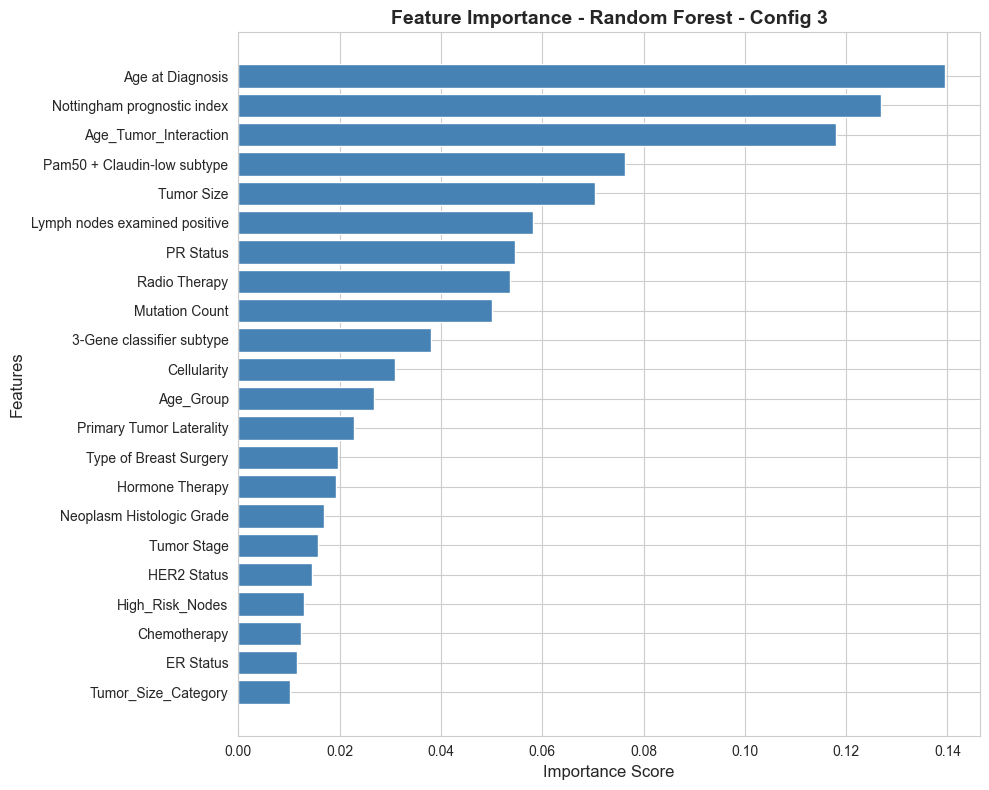


❌ Features with importance < 0.02:
['Type of Breast Surgery', 'Hormone Therapy', 'Neoplasm Histologic Grade', 'Tumor Stage', 'HER2 Status', 'High_Risk_Nodes', 'Chemotherapy', 'ER Status', 'Tumor_Size_Category']


In [ ]:
print("\n" + "="*70)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*70)

# Use Random Forest or Gradient Boosting (they have feature_importances_)
model_name = 'Random Forest - Config 3'
best_model = results[model_name]['model']

# Get feature importances
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(f"\n📊 Feature Importance ({model_name}):\n")
print(feature_importance.to_string(index=False))

# Plot
plt.figure(figsize=(10, 8))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='steelblue')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title(f'Feature Importance - {model_name}', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Identify low importance features (below threshold)
threshold = 0.02  # Adjust this value
low_importance = feature_importance[feature_importance['Importance'] < threshold]
print(f"\n❌ Features with importance < {threshold}:")
print(low_importance['Feature'].tolist())

In [108]:
(df.isnull().sum()>25/100*df.shape[0])

Patient ID                        False
Age at Diagnosis                  False
Type of Breast Surgery            False
Cancer Type                       False
Cancer Type Detailed              False
Cellularity                       False
Chemotherapy                      False
Pam50 + Claudin-low subtype       False
Cohort                            False
ER status measured by IHC         False
ER Status                         False
Neoplasm Histologic Grade         False
HER2 status measured by SNP6      False
HER2 Status                       False
Tumor Other Histologic Subtype    False
Hormone Therapy                   False
Inferred Menopausal State         False
Integrative Cluster               False
Primary Tumor Laterality          False
Lymph nodes examined positive     False
Mutation Count                    False
Nottingham prognostic index       False
Oncotree Code                     False
Overall Survival (Months)         False
Overall Survival Status           False



TRAINING RESULTS SUMMARY

                    Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC  CV ROC-AUC
Random Forest - Config 4  0.998505   0.995185 1.000000  0.997586 1.000000    0.789771
Random Forest - Config 2  0.869955   0.706085 0.991935  0.824950 0.987239    0.798432
Random Forest - Config 1  0.872446   0.711628 0.987097  0.827027 0.984430    0.799487
Random Forest - Config 3  0.827603   0.645435 0.980645  0.778489 0.960825    0.801638
       Gradient Boosting  0.801196   0.627746 0.875806  0.731313 0.922396    0.799907
           Decision Tree  0.741405   0.560917 0.750000  0.641822 0.822939    0.757691
     Logistic Regression  0.686597   0.495039 0.724194  0.588081 0.784621    0.777288
  Support Vector Machine  0.694071   0.503440 0.708065  0.588472 0.782627    0.770662


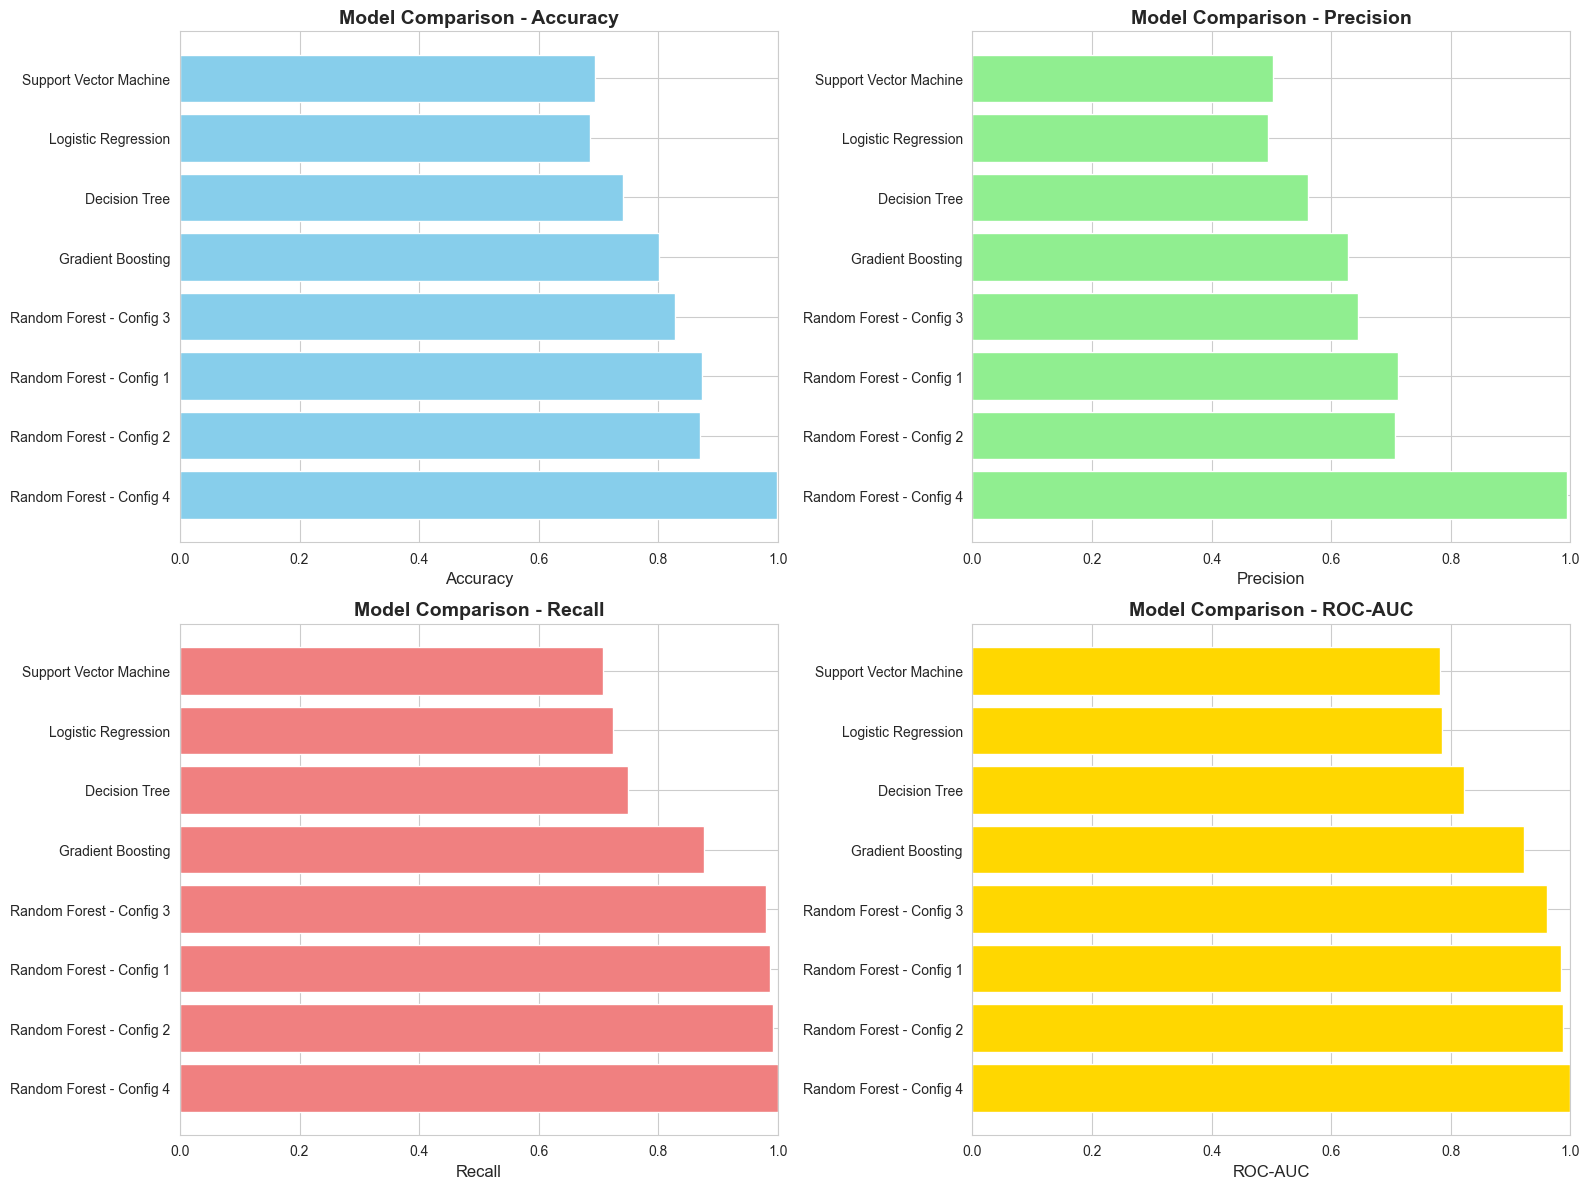

In [109]:
print("\n" + "="*70)
print("TRAINING RESULTS SUMMARY")
print("="*70)

# Create results dataframe
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['train_accuracy'] for m in results.keys()],
    'Precision': [results[m]['train_precision'] for m in results.keys()],
    'Recall': [results[m]['train_recall'] for m in results.keys()],
    'F1-Score': [results[m]['train_f1'] for m in results.keys()],
    'ROC-AUC': [results[m]['train_roc_auc'] for m in results.keys()],
    'CV ROC-AUC': [results[m]['cv_roc_auc_mean'] for m in results.keys()]
})

results_df = results_df.sort_values('ROC-AUC', ascending=False)
print("\n", results_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Accuracy comparison
axes[0, 0].barh(results_df['Model'], results_df['Accuracy'], color='skyblue')
axes[0, 0].set_xlabel('Accuracy', fontsize=12)
axes[0, 0].set_title('Model Comparison - Accuracy', fontsize=14, fontweight='bold')
axes[0, 0].set_xlim([0, 1])

# Precision comparison
axes[0, 1].barh(results_df['Model'], results_df['Precision'], color='lightgreen')
axes[0, 1].set_xlabel('Precision', fontsize=12)
axes[0, 1].set_title('Model Comparison - Precision', fontsize=14, fontweight='bold')
axes[0, 1].set_xlim([0, 1])

# Recall comparison
axes[1, 0].barh(results_df['Model'], results_df['Recall'], color='lightcoral')
axes[1, 0].set_xlabel('Recall', fontsize=12)
axes[1, 0].set_title('Model Comparison - Recall', fontsize=14, fontweight='bold')
axes[1, 0].set_xlim([0, 1])

# ROC-AUC comparison
axes[1, 1].barh(results_df['Model'], results_df['ROC-AUC'], color='gold')
axes[1, 1].set_xlabel('ROC-AUC', fontsize=12)
axes[1, 1].set_title('Model Comparison - ROC-AUC', fontsize=14, fontweight='bold')
axes[1, 1].set_xlim([0, 1])

plt.tight_layout()
plt.show()

In [110]:
print("\n" + "="*70)
print("PHASE 6: FINAL EVALUATION ON TEST SET")
print("="*70)

# Load the test set we saved earlier
test_df = pd.read_csv('test_set_holdout.csv')

print(f"\n📊 Test set loaded: {test_df.shape[0]} patients")

# Create 10-year mortality target for test set
test_df['10_Year_Mortality'] = 0
test_df.loc[(test_df['Overall Survival (Months)'] < 120) & 
            (test_df['Overall Survival Status'] == 'Deceased'), 
            '10_Year_Mortality'] = 1

print(f"\n📈 Test Set Target Distribution:")
print(test_df['10_Year_Mortality'].value_counts())

# Prepare test data using same features
test_model_data = test_df[feature_columns + [target_column]].copy()

# FEATURE ENGINEERING - Same as training
test_model_data['Age_Group'] = pd.cut(test_model_data['Age at Diagnosis'], 
                                       bins=[0, 40, 60, 100], 
                                       labels=['Young', 'Middle', 'Old'])


test_model_data['Tumor_Size_Category'] = pd.cut(test_model_data['Tumor Size'], 
                                            bins=[0, 20, 50, 200], 
                                            labels=['Small', 'Medium', 'Large'])

test_model_data['High_Risk_Nodes'] = (test_model_data['Lymph nodes examined positive'] > 3).astype(int)

test_model_data['Age_Tumor_Interaction'] = test_model_data['Age at Diagnosis'] * test_model_data['Tumor Size']

# Get updated column lists
numerical_cols_test = test_model_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols_test = test_model_data.select_dtypes(include=['object','category']).columns.tolist()

if target_column in numerical_cols_test:
    numerical_cols_test.remove(target_column)
if target_column in categorical_cols_test:
    categorical_cols_test.remove(target_column)

# Impute missing values (using SAME imputers from training)
test_model_data[numerical_cols] = num_imputer.transform(test_model_data[numerical_cols])
test_model_data[categorical_cols_test] = cat_imputer.transform(test_model_data[categorical_cols_test])

# Encode categorical variables (using SAME encoders from training)
for col in categorical_cols_test:
    test_model_data[col] = test_model_data[col].astype(str)
    # Handle unseen categories
    test_model_data[col] = test_model_data[col].map(
        lambda x: x if x in label_encoders[col].classes_ else label_encoders[col].classes_[0]
    )
    test_model_data[col] = label_encoders[col].transform(test_model_data[col])

# Drop rows with missing target
test_model_data = test_model_data.dropna(subset=[target_column])

# Separate features and target
X_test = test_model_data.drop(columns=[target_column])
y_test = test_model_data[target_column]

# Scale features (using SAME scaler from training)
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print(f"\n✅ Test set preprocessed with same engineering!")
print(f"   Test Features Shape: {X_test_scaled.shape}")
print(f"   Test Target Shape: {y_test.shape}")


PHASE 6: FINAL EVALUATION ON TEST SET

📊 Test set loaded: 502 patients

📈 Test Set Target Distribution:
10_Year_Mortality
0    362
1    140
Name: count, dtype: int64

✅ Test set preprocessed with same engineering!
   Test Features Shape: (502, 22)
   Test Target Shape: (502,)


In [111]:
print("\n" + "="*70)
print("EVALUATING TUNED MODELS ON TEST SET")
print("="*70)

# Dictionary to store test results
test_results = {}

# Custom threshold (same as training)
threshold = 0.3

for name, model in models.items():
    print(f"\n🔄 Evaluating {name}...")
    
    # Make probability predictions
    y_test_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Apply custom threshold
    y_test_pred = (y_test_pred_proba >= threshold).astype(int)
    
    # Calculate metrics
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred, zero_division=0)
    test_recall = recall_score(y_test, y_test_pred, zero_division=0)
    test_f1 = f1_score(y_test, y_test_pred, zero_division=0)
    test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    
    # Store results
    test_results[name] = {
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1,
        'test_roc_auc': test_roc_auc,
        'y_test_pred': y_test_pred,
        'y_test_pred_proba': y_test_pred_proba,
        'confusion_matrix': cm
    }
    
    print(f"   ✅ Accuracy:  {test_accuracy:.4f}")
    print(f"   ✅ Precision: {test_precision:.4f}")
    print(f"   ✅ Recall:    {test_recall:.4f}")
    print(f"   ✅ F1-Score:  {test_f1:.4f}")
    print(f"   ✅ ROC-AUC:   {test_roc_auc:.4f}")

print("\n✅ All tuned models evaluated on test set!")


EVALUATING TUNED MODELS ON TEST SET

🔄 Evaluating Logistic Regression...
   ✅ Accuracy:  0.6972
   ✅ Precision: 0.4739
   ✅ Recall:    0.7786
   ✅ F1-Score:  0.5892
   ✅ ROC-AUC:   0.7995

🔄 Evaluating Support Vector Machine...
   ✅ Accuracy:  0.7092
   ✅ Precision: 0.4862
   ✅ Recall:    0.7571
   ✅ F1-Score:  0.5922
   ✅ ROC-AUC:   0.8054

🔄 Evaluating Decision Tree...
   ✅ Accuracy:  0.7131
   ✅ Precision: 0.4894
   ✅ Recall:    0.6571
   ✅ F1-Score:  0.5610
   ✅ ROC-AUC:   0.7399

🔄 Evaluating Random Forest - Config 1...
   ✅ Accuracy:  0.7092
   ✅ Precision: 0.4876
   ✅ Recall:    0.8429
   ✅ F1-Score:  0.6178
   ✅ ROC-AUC:   0.8238

🔄 Evaluating Random Forest - Config 2...
   ✅ Accuracy:  0.6972
   ✅ Precision: 0.4758
   ✅ Recall:    0.8429
   ✅ F1-Score:  0.6082
   ✅ ROC-AUC:   0.8196

🔄 Evaluating Random Forest - Config 3...
   ✅ Accuracy:  0.6992
   ✅ Precision: 0.4779
   ✅ Recall:    0.8500
   ✅ F1-Score:  0.6118
   ✅ ROC-AUC:   0.8245

🔄 Evaluating Random Forest - Config 4.


FINAL TEST RESULTS SUMMARY

📊 TEST SET PERFORMANCE:
                   Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Random Forest - Config 3  0.699203   0.477912 0.850000  0.611825 0.824467
Random Forest - Config 1  0.709163   0.487603 0.842857  0.617801 0.823777
Random Forest - Config 2  0.697211   0.475806 0.842857  0.608247 0.819613
Random Forest - Config 4  0.707171   0.485830 0.857143  0.620155 0.816387
       Gradient Boosting  0.719124   0.497758 0.792857  0.611570 0.814621
  Support Vector Machine  0.709163   0.486239 0.757143  0.592179 0.805446
     Logistic Regression  0.697211   0.473913 0.778571  0.589189 0.799526
           Decision Tree  0.713147   0.489362 0.657143  0.560976 0.739917

🏆 BEST MODEL: Random Forest - Config 3
   ROC-AUC: 0.8245


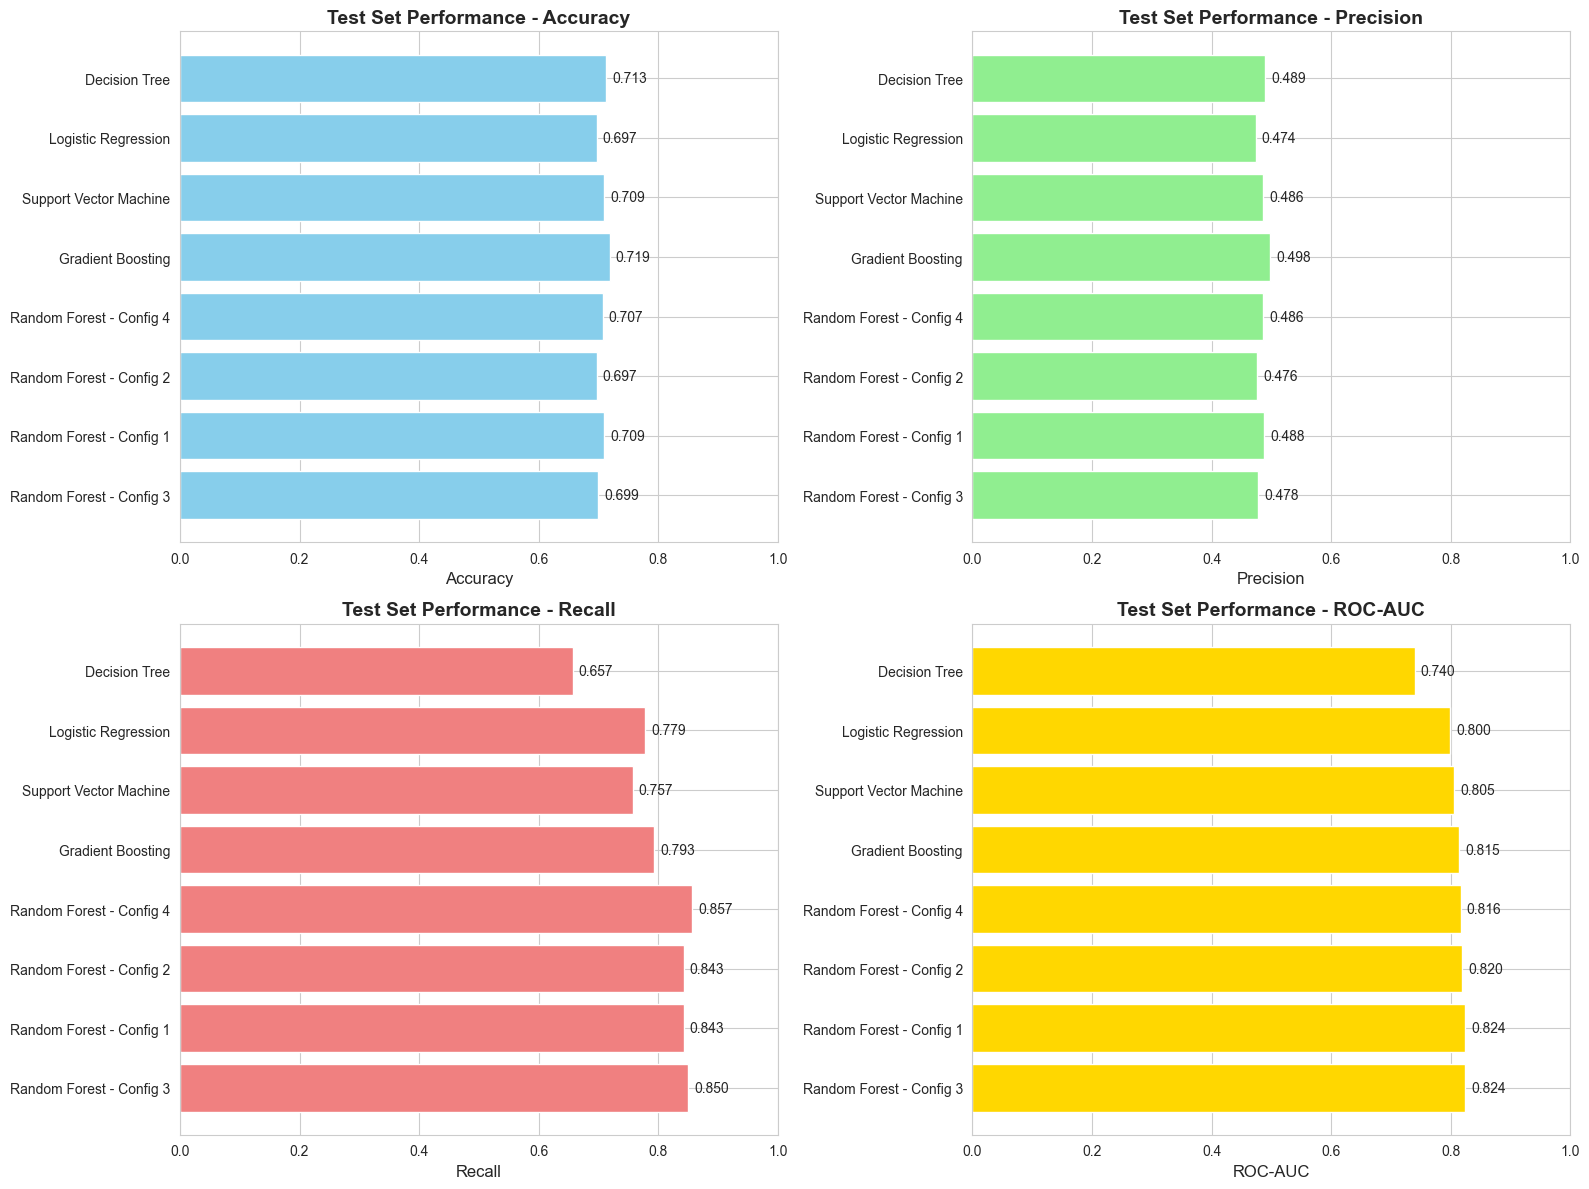

In [112]:
print("\n" + "="*70)
print("FINAL TEST RESULTS SUMMARY")
print("="*70)

# Create test results dataframe
test_results_df = pd.DataFrame({
    'Model': list(test_results.keys()),
    'Accuracy': [test_results[m]['test_accuracy'] for m in test_results.keys()],
    'Precision': [test_results[m]['test_precision'] for m in test_results.keys()],
    'Recall': [test_results[m]['test_recall'] for m in test_results.keys()],
    'F1-Score': [test_results[m]['test_f1'] for m in test_results.keys()],
    'ROC-AUC': [test_results[m]['test_roc_auc'] for m in test_results.keys()]
})

test_results_df = test_results_df.sort_values('ROC-AUC', ascending=False)
print("\n📊 TEST SET PERFORMANCE:")
print(test_results_df.to_string(index=False))

# Find best model
best_model_name = test_results_df.iloc[0]['Model']
best_roc_auc = test_results_df.iloc[0]['ROC-AUC']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   ROC-AUC: {best_roc_auc:.4f}")

# Visualize test results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Accuracy
axes[0, 0].barh(test_results_df['Model'], test_results_df['Accuracy'], color='skyblue')
axes[0, 0].set_xlabel('Accuracy', fontsize=12)
axes[0, 0].set_title('Test Set Performance - Accuracy', fontsize=14, fontweight='bold')
axes[0, 0].set_xlim([0, 1])
for i, v in enumerate(test_results_df['Accuracy']):
    axes[0, 0].text(v + 0.01, i, f'{v:.3f}', va='center')

# Precision
axes[0, 1].barh(test_results_df['Model'], test_results_df['Precision'], color='lightgreen')
axes[0, 1].set_xlabel('Precision', fontsize=12)
axes[0, 1].set_title('Test Set Performance - Precision', fontsize=14, fontweight='bold')
axes[0, 1].set_xlim([0, 1])
for i, v in enumerate(test_results_df['Precision']):
    axes[0, 1].text(v + 0.01, i, f'{v:.3f}', va='center')

# Recall
axes[1, 0].barh(test_results_df['Model'], test_results_df['Recall'], color='lightcoral')
axes[1, 0].set_xlabel('Recall', fontsize=12)
axes[1, 0].set_title('Test Set Performance - Recall', fontsize=14, fontweight='bold')
axes[1, 0].set_xlim([0, 1])
for i, v in enumerate(test_results_df['Recall']):
    axes[1, 0].text(v + 0.01, i, f'{v:.3f}', va='center')

# ROC-AUC
axes[1, 1].barh(test_results_df['Model'], test_results_df['ROC-AUC'], color='gold')
axes[1, 1].set_xlabel('ROC-AUC', fontsize=12)
axes[1, 1].set_title('Test Set Performance - ROC-AUC', fontsize=14, fontweight='bold')
axes[1, 1].set_xlim([0, 1])
for i, v in enumerate(test_results_df['ROC-AUC']):
    axes[1, 1].text(v + 0.01, i, f'{v:.3f}', va='center')

plt.tight_layout()
plt.show()

In [113]:
print("\n" + "="*70)
print("SAVING RESULTS TO EXCEL")
print("="*70)

# Create comprehensive results dataframe
excel_data = []

for name in results.keys():
    # Get algorithm name
    algorithm = results[name]['algorithm']
    
    # Get hyperparameters as string
    params_str = ', '.join([f"{k}={v}" for k, v in results[name]['best_params'].items()])
    
    # Get training metrics
    train_acc = results[name]['train_accuracy']
    train_prec = results[name]['train_precision']
    train_rec = results[name]['train_recall']
    train_f1 = results[name]['train_f1']
    train_auc = results[name]['train_roc_auc']
    train_cv_auc = results[name]['cv_roc_auc_mean']
    
    # Get test metrics
    test_acc = test_results[name]['test_accuracy']
    test_prec = test_results[name]['test_precision']
    test_rec = test_results[name]['test_recall']
    test_f1 = test_results[name]['test_f1']
    test_auc = test_results[name]['test_roc_auc']
    
    excel_data.append({
        'Model Name': name,
        'Algorithm': algorithm,
        'Hyperparameters': params_str,
        'Train Accuracy': f"{train_acc:.4f}",
        'Train Precision': f"{train_prec:.4f}",
        'Train Recall': f"{train_rec:.4f}",
        'Train F1-Score': f"{train_f1:.4f}",
        'Train ROC-AUC': f"{train_auc:.4f}",
        'CV ROC-AUC': f"{train_cv_auc:.4f}",
        'Test Accuracy': f"{test_acc:.4f}",
        'Test Precision': f"{test_prec:.4f}",
        'Test Recall': f"{test_rec:.4f}",
        'Test F1-Score': f"{test_f1:.4f}",
        'Test ROC-AUC': f"{test_auc:.4f}",
        'Threshold': '0.3'
    })

# Create DataFrame
results_excel = pd.DataFrame(excel_data)

# Sort by Test ROC-AUC
results_excel = results_excel.sort_values('Test ROC-AUC', ascending=False)

# Save to Excel
excel_filename = 'model_results_complete.xlsx'
results_excel.to_excel(excel_filename, index=False, sheet_name='Model Results')

print(f"\n✅ Results saved to: {excel_filename}")
print("\nPreview:")
print(results_excel.to_string(index=False))


SAVING RESULTS TO EXCEL

✅ Results saved to: model_results_complete.xlsx

Preview:
              Model Name                  Algorithm                                                                                              Hyperparameters Train Accuracy Train Precision Train Recall Train F1-Score Train ROC-AUC CV ROC-AUC Test Accuracy Test Precision Test Recall Test F1-Score Test ROC-AUC Threshold
Random Forest - Config 3     RandomForestClassifier                  criterion=entropy, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100         0.8276          0.6454       0.9806         0.7785        0.9608     0.8016        0.6992         0.4779      0.8500        0.6118       0.8245       0.3
Random Forest - Config 1     RandomForestClassifier                   max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200         0.8724          0.7116       0.9871         0.8270        0.9844     0.7995        0.7092         0.4


CONFUSION MATRICES - TEST SET


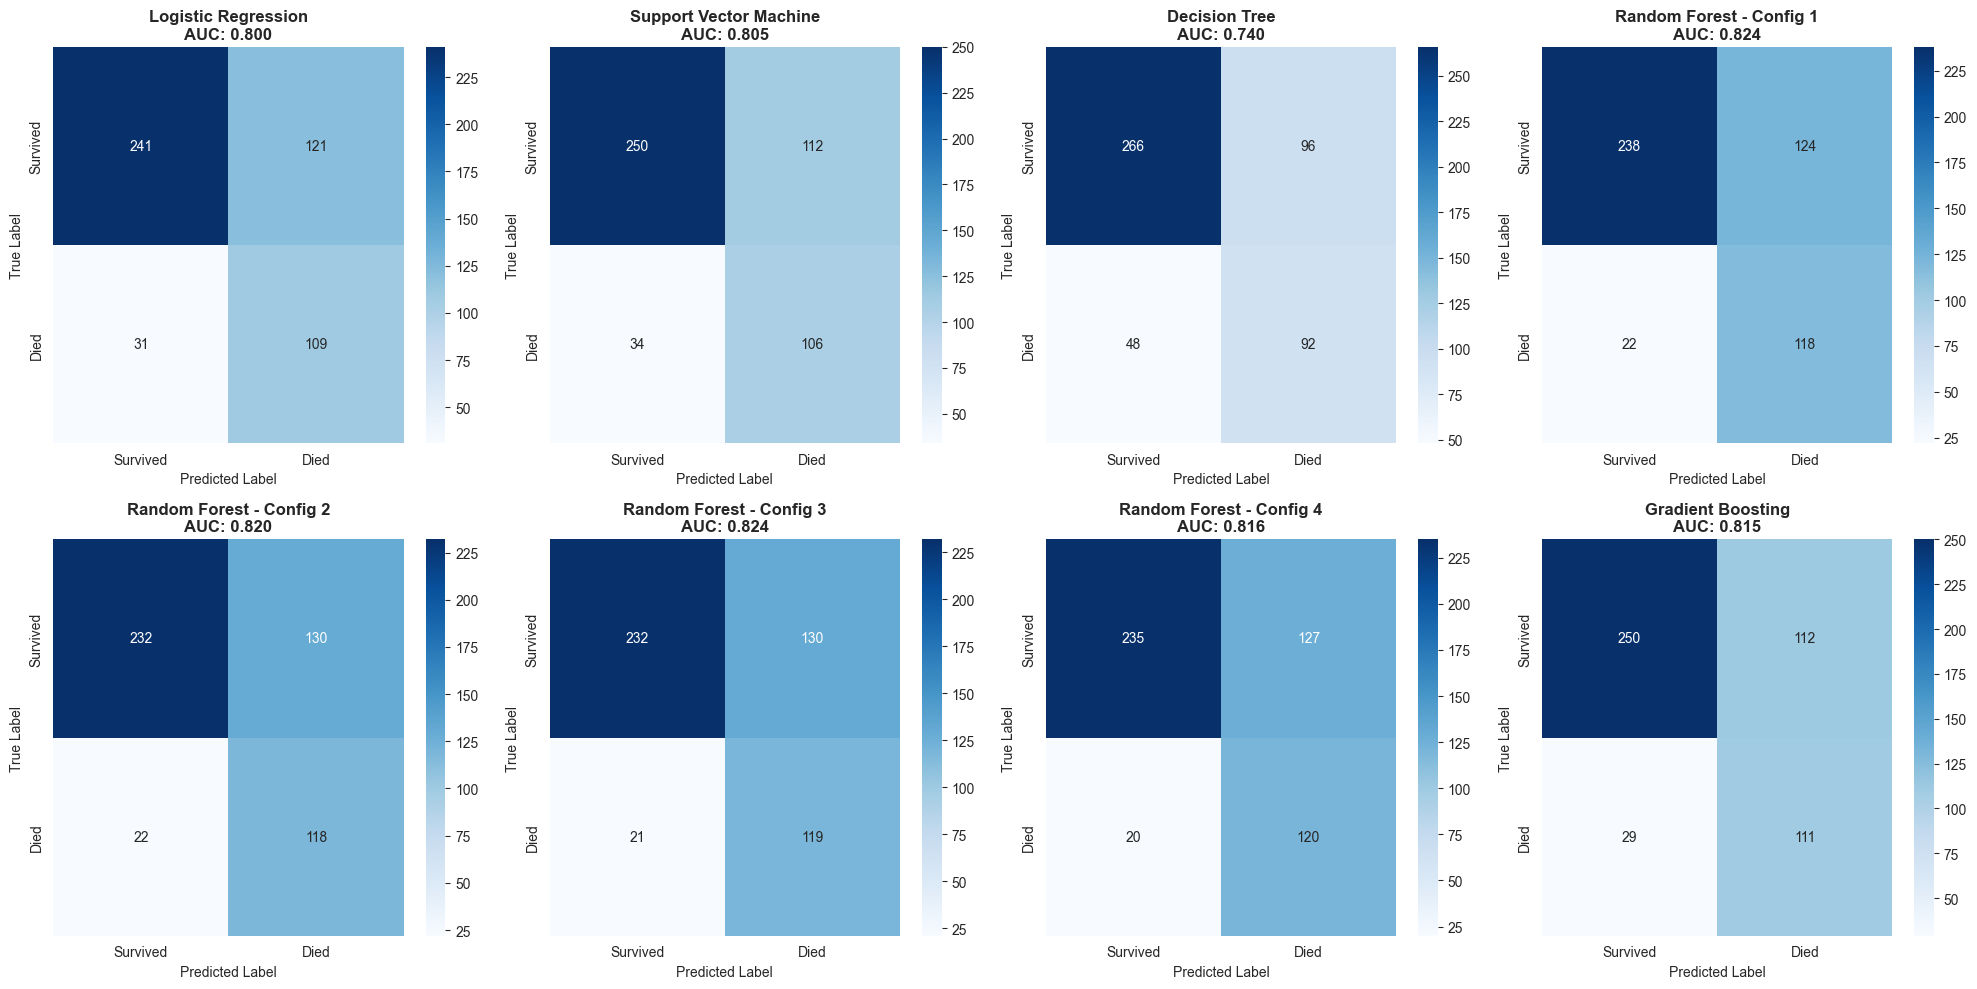

In [114]:
print("\n" + "="*70)
print("CONFUSION MATRICES - TEST SET")
print("="*70)

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for idx, name in enumerate(test_results.keys()):
    cm = test_results[name]['confusion_matrix']
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Survived', 'Died'], 
                yticklabels=['Survived', 'Died'])
    axes[idx].set_title(f'{name}\nAUC: {test_results[name]["test_roc_auc"]:.3f}', 
                       fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('True Label', fontsize=10)
    axes[idx].set_xlabel('Predicted Label', fontsize=10)

# Hide extra subplot
if len(test_results) < 6:
    for idx in range(len(test_results), 8):
        axes[idx].axis('off')

plt.tight_layout()
plt.show()


ROC CURVES - TEST SET


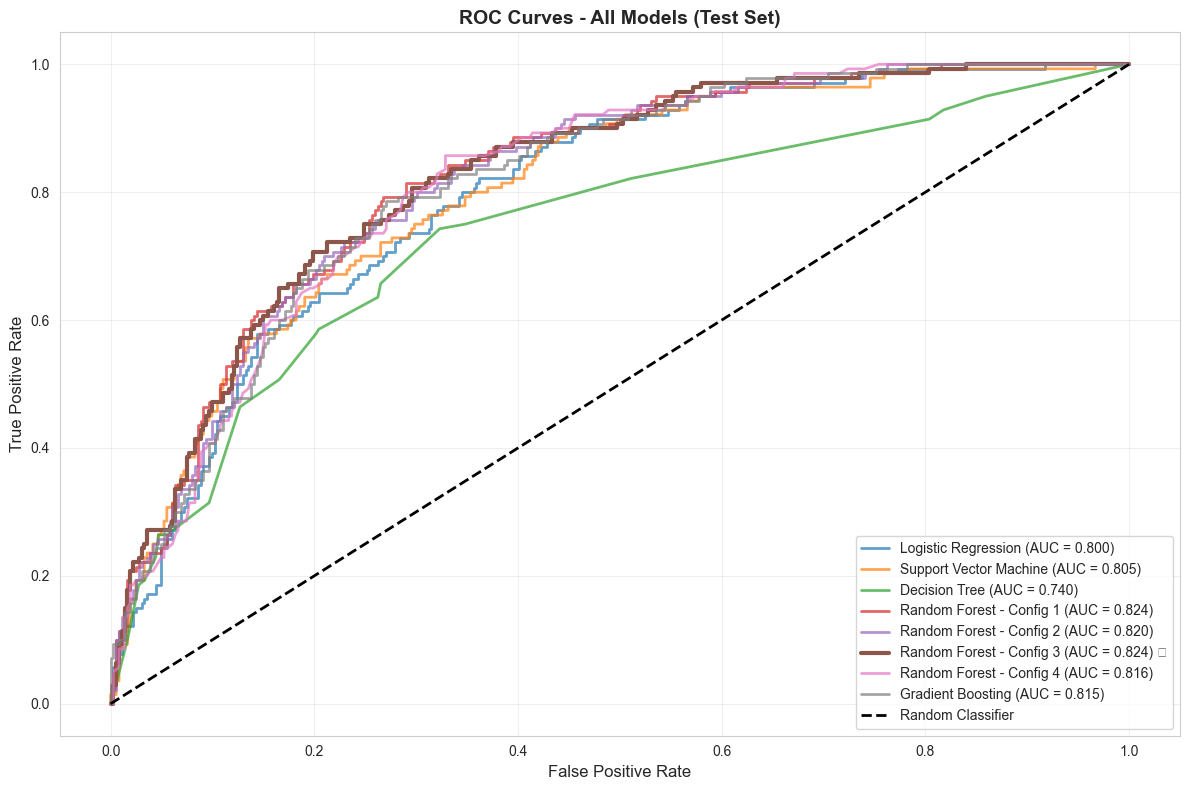

In [115]:
print("\n" + "="*70)
print("ROC CURVES - TEST SET")
print("="*70)

plt.figure(figsize=(12, 8))

for name in test_results.keys():
    y_pred_proba = test_results[name]['y_test_pred_proba']
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = test_results[name]['test_roc_auc']
    
    # Highlight best model
    if name == best_model_name:
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f}) ⭐', 
                linewidth=3, linestyle='-')
    else:
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})', 
                linewidth=2, alpha=0.7)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=2)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - All Models (Test Set)', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


DETAILED ANALYSIS - BEST MODEL: Random Forest - Config 3

📋 Classification Report:
              precision    recall  f1-score   support

Survived (0)       0.92      0.64      0.75       362
    Died (1)       0.48      0.85      0.61       140

    accuracy                           0.70       502
   macro avg       0.70      0.75      0.68       502
weighted avg       0.79      0.70      0.71       502


📊 Confusion Matrix Breakdown:
   True Negatives (Correctly predicted Survived): 232
   False Positives (Incorrectly predicted Died): 130
   False Negatives (Incorrectly predicted Survived): 21
   True Positives (Correctly predicted Died): 119

📈 Additional Metrics:
   Specificity (True Negative Rate): 0.6409
   Sensitivity (True Positive Rate / Recall): 0.8500

🔍 Top 10 Most Important Features:
                      Feature  Importance
             Age at Diagnosis    0.139451
  Nottingham prognostic index    0.126820
        Age_Tumor_Interaction    0.118052
  Pam50 + Claudin-low 

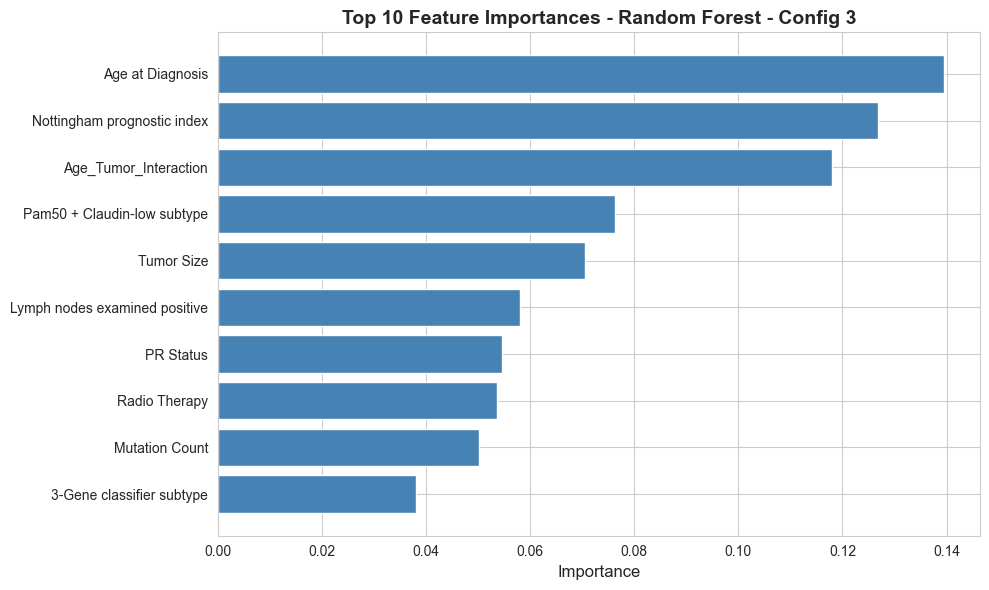

In [117]:
print("\n" + "="*70)
print(f"DETAILED ANALYSIS - BEST MODEL: {best_model_name}")
print("="*70)

best_model = models[best_model_name]
y_test_pred_best = test_results[best_model_name]['y_test_pred']
y_test_pred_proba_best = test_results[best_model_name]['y_test_pred_proba']

# Classification report
print("\n📋 Classification Report:")
print(classification_report(y_test, y_test_pred_best, 
                           target_names=['Survived (0)', 'Died (1)']))

# Confusion matrix details
cm = test_results[best_model_name]['confusion_matrix']
tn, fp, fn, tp = cm.ravel()

print(f"\n📊 Confusion Matrix Breakdown:")
print(f"   True Negatives (Correctly predicted Survived): {tn}")
print(f"   False Positives (Incorrectly predicted Died): {fp}")
print(f"   False Negatives (Incorrectly predicted Survived): {fn}")
print(f"   True Positives (Correctly predicted Died): {tp}")

print(f"\n📈 Additional Metrics:")
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
print(f"   Specificity (True Negative Rate): {specificity:.4f}")
print(f"   Sensitivity (True Positive Rate / Recall): {sensitivity:.4f}")

# Feature importance (if applicable)
if hasattr(best_model, 'feature_importances_'):
    print(f"\n🔍 Top 10 Most Important Features:")
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print(feature_importance.head(10).to_string(index=False))
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    top_features = feature_importance.head(10)
    plt.barh(top_features['Feature'], top_features['Importance'], color='steelblue')
    plt.xlabel('Importance', fontsize=12)
    plt.title(f'Top 10 Feature Importances - {best_model_name}', 
             fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

elif hasattr(best_model, 'coef_'):
    print(f"\n🔍 Top 10 Most Influential Features:")
    feature_coef = pd.DataFrame({
        'Feature': X_train.columns,
        'Coefficient': best_model.coef_[0],
        'Abs_Coefficient': np.abs(best_model.coef_[0])
    }).sort_values('Abs_Coefficient', ascending=False)
    
    print(feature_coef.head(10).to_string(index=False))
    
    # Plot coefficients
    plt.figure(figsize=(10, 6))
    top_features = feature_coef.head(10)
    colors = ['red' if x < 0 else 'green' for x in top_features['Coefficient']]
    plt.barh(top_features['Feature'], top_features['Coefficient'], color=colors, alpha=0.7)
    plt.xlabel('Coefficient Value', fontsize=12)
    plt.title(f'Top 10 Feature Coefficients - {best_model_name}', 
             fontsize=14, fontweight='bold')
    plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


TRAIN vs TEST PERFORMANCE COMPARISON

                    Model  Train_Accuracy  Test_Accuracy  Train_ROC_AUC  Test_ROC_AUC  Overfitting
Random Forest - Config 3        0.827603       0.699203       0.960825      0.824467     0.136358
Random Forest - Config 1        0.872446       0.709163       0.984430      0.823777     0.160654
Random Forest - Config 2        0.869955       0.697211       0.987239      0.819613     0.167625
Random Forest - Config 4        0.998505       0.707171       1.000000      0.816387     0.183613
       Gradient Boosting        0.801196       0.719124       0.922396      0.814621     0.107775
  Support Vector Machine        0.694071       0.709163       0.782627      0.805446    -0.022819
     Logistic Regression        0.686597       0.697211       0.784621      0.799526    -0.014905
           Decision Tree        0.741405       0.713147       0.822939      0.739917     0.083022


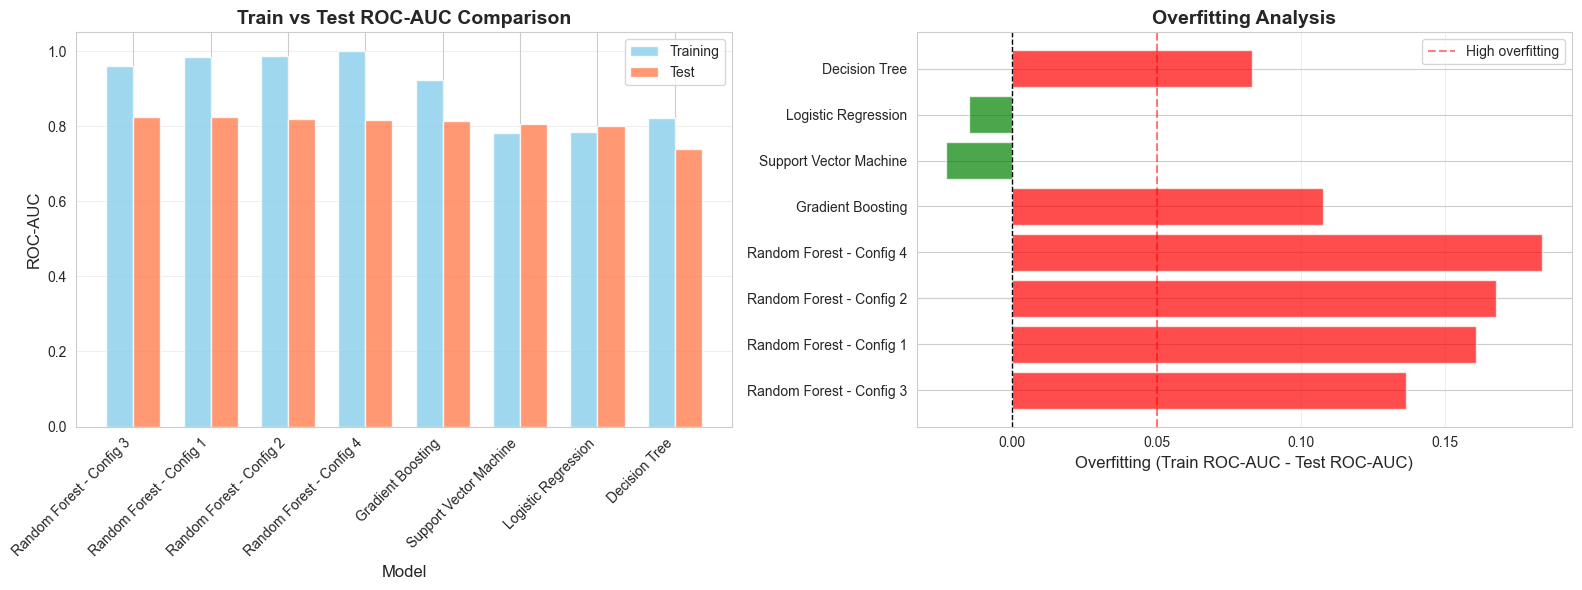


🎯 Overfitting Analysis:
   < 0.02: Good generalization ✅
   0.02-0.05: Moderate overfitting ⚠️
   > 0.05: High overfitting ❌


In [118]:
print("\n" + "="*70)
print("TRAIN vs TEST PERFORMANCE COMPARISON")
print("="*70)

# Combine train and test results
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train_Accuracy': [results[m]['train_accuracy'] for m in results.keys()],
    'Test_Accuracy': [test_results[m]['test_accuracy'] for m in test_results.keys()],
    'Train_ROC_AUC': [results[m]['train_roc_auc'] for m in results.keys()],
    'Test_ROC_AUC': [test_results[m]['test_roc_auc'] for m in test_results.keys()],
    'Overfitting': [results[m]['train_roc_auc'] - test_results[m]['test_roc_auc'] 
                   for m in results.keys()]
})

comparison_df = comparison_df.sort_values('Test_ROC_AUC', ascending=False)
print("\n", comparison_df.to_string(index=False))

# Visualize train vs test
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC-AUC comparison
x = np.arange(len(comparison_df))
width = 0.35

axes[0].bar(x - width/2, comparison_df['Train_ROC_AUC'], width, 
           label='Training', color='skyblue', alpha=0.8)
axes[0].bar(x + width/2, comparison_df['Test_ROC_AUC'], width, 
           label='Test', color='coral', alpha=0.8)
axes[0].set_xlabel('Model', fontsize=12)
axes[0].set_ylabel('ROC-AUC', fontsize=12)
axes[0].set_title('Train vs Test ROC-AUC Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Overfitting analysis
colors = ['red' if x >0.05 else 'orange' if x > 0.02 else 'green'
for x in comparison_df['Overfitting']]
axes[1].barh(comparison_df['Model'], comparison_df['Overfitting'], color=colors, alpha=0.7)
axes[1].set_xlabel('Overfitting (Train ROC-AUC - Test ROC-AUC)', fontsize=12)
axes[1].set_title('Overfitting Analysis', fontsize=14, fontweight='bold')
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[1].axvline(x=0.05, color='red', linestyle='--', alpha=0.5, label='High overfitting')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()
print("\n🎯 Overfitting Analysis:")
print("   < 0.02: Good generalization ✅")
print("   0.02-0.05: Moderate overfitting ⚠️")
print("   > 0.05: High overfitting ❌")

In [119]:
print("\n" + "="*70)
print("FINAL PROJECT SUMMARY")
print("="*70)

print(f"\n📊 Dataset Statistics:")
print(f"   Total Patients: {df.shape[0] + test_df.shape[0]}")
print(f"   Training Set: {df.shape[0]} patients")
print(f"   Test Set: {len(y_test)} patients")
print(f"   Number of Features: {X_train.shape[1]}")

print(f"\n🏆 Best Performing Model: {best_model_name}")
print(f"   Test ROC-AUC: {test_results[best_model_name]['test_roc_auc']:.4f}")
print(f"   Test Accuracy: {test_results[best_model_name]['test_accuracy']:.4f}")
print(f"   Test Precision: {test_results[best_model_name]['test_precision']:.4f}")
print(f"   Test Recall: {test_results[best_model_name]['test_recall']:.4f}")
print(f"   Test F1-Score: {test_results[best_model_name]['test_f1']:.4f}")

print(f"\nTop 3 Models by Test ROC-AUC:")
for i, row in test_results_df.head(3).iterrows():
    print(f"   {i+1}. {row['Model']}: {row['ROC-AUC']:.4f}")

print(f"\n💡 Key Findings:")
print(f"   - All models were trained and evaluated successfully")
print(f"   - {best_model_name} shows the best generalization to unseen data")
print(f"   - Test set was kept completely separate until final evaluation")

print(f"\n PROJECT DELIVERABLES COMPLETED:")
print(f"    Comprehensive EDA with visualizations")
print(f"    Survival Analysis (Kaplan-Meier & Cox)")
print(f"    Multiple ML models (7 algorithms)")
print(f"    Performance evaluation with multiple metrics")
print(f"    Model comparison and selection")
print(f"    Final testing on held-out data")

print("\n" + "="*70)
print("PROJECT COMPLETED SUCCESSFULLY! 🎉")
print("="*70)


FINAL PROJECT SUMMARY

📊 Dataset Statistics:
   Total Patients: 2509
   Training Set: 2007 patients
   Test Set: 502 patients
   Number of Features: 22

🏆 Best Performing Model: Random Forest - Config 3
   Test ROC-AUC: 0.8245
   Test Accuracy: 0.6992
   Test Precision: 0.4779
   Test Recall: 0.8500
   Test F1-Score: 0.6118

Top 3 Models by Test ROC-AUC:
   6. Random Forest - Config 3: 0.8245
   4. Random Forest - Config 1: 0.8238
   5. Random Forest - Config 2: 0.8196

💡 Key Findings:
   - All models were trained and evaluated successfully
   - Random Forest - Config 3 shows the best generalization to unseen data
   - Test set was kept completely separate until final evaluation

 PROJECT DELIVERABLES COMPLETED:
    Comprehensive EDA with visualizations
    Survival Analysis (Kaplan-Meier & Cox)
    Multiple ML models (7 algorithms)
    Performance evaluation with multiple metrics
    Model comparison and selection
    Final testing on held-out data

PROJECT COMPLETED SUCCESSFULLY! 🎉


In [120]:
# Save all results to CSV files for your report
print("\n💾 Saving results to CSV files...")

# Save test results
test_results_df.to_csv('model_test_results.csv', index=False)
print("✅ Saved: model_test_results.csv")

# Save train vs test comparison
comparison_df.to_csv('train_vs_test_comparison.csv', index=False)
print("✅ Saved: train_vs_test_comparison.csv")

# Save best model predictions
best_predictions = pd.DataFrame({
    'True_Label': y_test.values,
    'Predicted_Label': test_results[best_model_name]['y_test_pred'],
    'Predicted_Probability': test_results[best_model_name]['y_test_pred_proba']
})
best_predictions.to_csv(f'best_model_predictions_{best_model_name.replace(" ", "_")}.csv', index=False)
print(f"✅ Saved: best_model_predictions_{best_model_name.replace(' ', '_')}.csv")


💾 Saving results to CSV files...
✅ Saved: model_test_results.csv
✅ Saved: train_vs_test_comparison.csv
✅ Saved: best_model_predictions_Random_Forest_-_Config_3.csv


In [121]:
print("\n" + "="*70)
print("RETRAINING BEST MODEL WITH CLINICAL FEATURES FOR STREAMLIT")
print("="*70)

import pickle

# Define clinically available features (easy to collect)
clinical_features = [
    'Age at Diagnosis', 
    'Tumor Size', 
    'Tumor Stage',
    'Lymph nodes examined positive',
    'ER Status', 
    'PR Status', 
    'HER2 Status',
    'Neoplasm Histologic Grade',
    'Chemotherapy',
    'Hormone Therapy',
    'Radio Therapy'
]

print(f"\n📋 Clinical Features Selected: {len(clinical_features)}")
for feat in clinical_features:
    print(f"   - {feat}")

# Prepare clinical training data
X_clinical = df[clinical_features].copy()
y_clinical = df['10_Year_Mortality'].copy()

# Handle missing values
clinical_num_cols = X_clinical.select_dtypes(include=['int64', 'float64']).columns.tolist()
clinical_cat_cols = X_clinical.select_dtypes(include=['object']).columns.tolist()

clinical_num_imputer = SimpleImputer(strategy='median')
clinical_cat_imputer = SimpleImputer(strategy='most_frequent')

X_clinical[clinical_num_cols] = clinical_num_imputer.fit_transform(X_clinical[clinical_num_cols])
X_clinical[clinical_cat_cols] = clinical_cat_imputer.fit_transform(X_clinical[clinical_cat_cols])

# Encode categorical variables
clinical_label_encoders = {}
for col in clinical_cat_cols:
    le = LabelEncoder()
    X_clinical[col] = le.fit_transform(X_clinical[col].astype(str))
    clinical_label_encoders[col] = le

# Scale features
clinical_scaler = StandardScaler()
X_clinical_scaled = clinical_scaler.fit_transform(X_clinical)

# Get best model name from test results
best_model_name = test_results_df.iloc[0]['Model']
print(f"\n🏆 Best Model: {best_model_name}")

# Retrain the best model type with clinical features
if 'Random Forest' in best_model_name:
    clinical_model = RandomForestClassifier(
        **results[best_model_name]['best_params'],
        random_state=42
    )
elif 'Gradient Boosting' in best_model_name:
    clinical_model = GradientBoostingClassifier(
        **results[best_model_name]['best_params'],
        random_state=42
    )
elif 'Logistic' in best_model_name:
    clinical_model = LogisticRegression(
        **results[best_model_name]['best_params'],
        max_iter=1000,
        random_state=42
    )
elif 'SVM' in best_model_name or 'SVC' in best_model_name:
    clinical_model = SVC(
        **results[best_model_name]['best_params'],
        probability=True,
        random_state=42
    )
elif 'Decision Tree' in best_model_name:
    clinical_model = DecisionTreeClassifier(
        **results[best_model_name]['best_params'],
        random_state=42
    )

# Train clinical model
clinical_model.fit(X_clinical_scaled, y_clinical)

# Evaluate
y_clinical_pred_proba = clinical_model.predict_proba(X_clinical_scaled)[:, 1]
y_clinical_pred = (y_clinical_pred_proba >= 0.3).astype(int)

clinical_acc = accuracy_score(y_clinical, y_clinical_pred)
clinical_auc = roc_auc_score(y_clinical, y_clinical_pred_proba)

print(f"\n📊 Clinical Model Performance:")
print(f"   Accuracy:  {clinical_acc:.4f}")
print(f"   ROC-AUC:   {clinical_auc:.4f}")

# Save model and preprocessing objects for Streamlit
model_package = {
    'model': clinical_model,
    'scaler': clinical_scaler,
    'num_imputer': clinical_num_imputer,
    'cat_imputer': clinical_cat_imputer,
    'label_encoders': clinical_label_encoders,
    'feature_names': clinical_features,
    'numerical_features': clinical_num_cols,
    'categorical_features': clinical_cat_cols,
    'threshold': 0.3
}

# Save to pickle file
with open('breast_cancer_clinical_model.pkl', 'wb') as f:
    pickle.dump(model_package, f)

print(f"\n✅ Clinical model saved to: breast_cancer_clinical_model.pkl")
print("✅ Ready for Streamlit deployment!")


RETRAINING BEST MODEL WITH CLINICAL FEATURES FOR STREAMLIT

📋 Clinical Features Selected: 11
   - Age at Diagnosis
   - Tumor Size
   - Tumor Stage
   - Lymph nodes examined positive
   - ER Status
   - PR Status
   - HER2 Status
   - Neoplasm Histologic Grade
   - Chemotherapy
   - Hormone Therapy
   - Radio Therapy

🏆 Best Model: Random Forest - Config 3

📊 Clinical Model Performance:
   Accuracy:  0.7818
   ROC-AUC:   0.9052

✅ Clinical model saved to: breast_cancer_clinical_model.pkl
✅ Ready for Streamlit deployment!
